# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [1]:
# parameters
# experiment_results = "results/human-combined.yaml"
results_dir = "results/human/gpt4"

In [2]:
!pip --version

pip 23.0.1 from /Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
!pip list

Package                    Version
-------------------------- ------------
adeft                      0.11.2
aiohttp                    3.8.5
aiosignal                  1.3.1
airium                     0.2.5
altair                     5.1.1
aniso8601                  9.0.1
annotated-types            0.5.0
antlr4-python3-runtime     4.9.3
anyio                      4.0.0
appdirs                    1.4.4
appnope                    0.1.3
argon2-cffi                23.1.0
argon2-cffi-bindings       21.2.0
arrow                      1.2.3
asttokens                  2.4.0
async-lru                  2.0.4
async-timeout              4.0.3
attrs                      23.1.0
Babel                      2.12.1
backcall                   0.2.0
bcp47                      0.0.4
beautifulsoup4             4.12.2
bioc                       2.1
bleach                     6.0.0
blinker                    1.6.2
boto3                      1.28.45
botocore                   1.31.45
cachetools                

In [4]:
import yaml
from yaml import Loader
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorsys
import seaborn as sns
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ruamel is faster
from ruamel.yaml import YAML
ryaml = YAML()

In [6]:
#from ontogpt.utils.gene_set_utils import populate_ids_and_symbols, GeneSet
#ee = EvalEnrichment()
#ee.ontology = go
#ee.load_annotations("../tests/input/genes2go.tsv.gz")

In [7]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [88]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top term"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "geneset"
PROMPT_VARIANT = "prompt_variant"
SOURCE_GENESET = "source geneset"
GENESET_DESCRIPTION = "description"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_GO_TERMS = "num GO terms"
UNPARSED = "unparsed"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"
GO_TERM_IDS = "go term ids"
GO_TERM_P_VALUES = "go term p values"
MAX_P_VALUE = "max p value"
MIN_P_VALUE = "min p value"
MEAN_P_VALUE = "mean p value"
PROPOTION_SIGNIFICANT = "proportion significant"
NOVEL = "unannotated"
NOVEL_LABELS = "unannotated labels"
NUM_NOVEL = "num unannotated"
GENE_RANDOMIZATION_FACTOR = "gene_randomization_factor"
SUMMARY = "summary"
TP_num = "number of true positives across a set of gene GO annotations"
FP_num = "number of false positives across a set of gene GO annotations"
TP = "true positive rate across a set of gene GO annotations"
FP = "false positive rate across a set of gene GO annotations"


In [9]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison

In [10]:
# assumes comparisons have been run and concatenated (see Makefile) 
import glob
def load_comparisons():
    comps = []
    for fn in glob.glob(f"{results_dir}/*.yaml"):
        print(fn)
        with open(fn) as f:
            #obj = yaml.load(f, Loader)
            #obj = yaml.safe_load(f)
            obj = ryaml.load(f)
            comps.extend([GeneSetComparison(**x) for x in obj])
    return comps

In [11]:
comps = load_comparisons()

results/human/gpt4/canonical-glycolysis-gocam-results-2.yaml
results/human/gpt4/bicluster_RNAseqDB_1001-results-2.yaml
results/human/gpt4/HALLMARK_HYPOXIA-results-2.yaml
results/human/gpt4/HALLMARK_DNA_REPAIR-results-2.yaml
results/human/gpt4/HALLMARK_G2M_CHECKPOINT-results-2.yaml
results/human/gpt4/EDS-results-2.yaml
results/human/gpt4/HALLMARK_IL2_STAT5_SIGNALING-results-2.yaml
results/human/gpt4/HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION-results-2.yaml
results/human/gpt4/HALLMARK_PI3K_AKT_MTOR_SIGNALING-results-2.yaml
results/human/gpt4/HALLMARK_COAGULATION-results-2.yaml
results/human/gpt4/peroxisome-results-2.yaml
results/human/gpt4/HALLMARK_APICAL_JUNCTION-results-2.yaml
results/human/gpt4/HALLMARK_ANGIOGENESIS-results-2.yaml
results/human/gpt4/go-postsynapse-calcium-results-2.yaml
results/human/gpt4/HALLMARK_BILE_ACID_METABOLISM-results-2.yaml
results/human/gpt4/HALLMARK_CHOLESTEROL_HOMEOSTASIS-results-2.yaml
results/human/gpt4/bicluster_RNAseqDB_1002-results-2.yaml
results/huma

In [12]:
len(comps)

144

In [13]:

def filter_redundant(term_ids):
    """
    find leaf nodes in a set of term ids
    """
    cumulative_ancs = set()
    visited = set()
    for t in term_ids:
        visited.add(t)
        if t in cumulative_ancs:
            # a descendant of t has been encountered
            continue
        ancs = list(go.ancestors(t, [IS_A, PART_OF]))
        cumulative_ancs.update(ancs)
        if (visited-{t}).intersection(ancs):
            # t is a descendant of a term that has been encountered
            continue
        yield t

# test
list(filter_redundant(["GO:0005773", "GO:0005634", "GO:0031965", "GO:0008150"]))

['GO:0005773', 'GO:0005634', 'GO:0008150']

In [158]:
import statistics
import re
def eval_payload(comp, payload, expected, closure):
    """
    Create a dataframe row from a payload in a comparison
    """
    expected_nr_ids = list(filter_redundant(expected.term_ids))
    name = comp.name
    model = payload.model
    method = payload.method
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    unparsed_term_ids = [t for t in payload.term_ids if not re.match(r'^\S+:w+$', t)]
    go_term_ids = [t for t in payload.term_ids if t.startswith("GO:")]
    nr_term_ids = list(filter_redundant(go_term_ids))
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf, PROMPT_VARIANT: payload.prompt_variant}
    obj[SUMMARY] = payload.summary
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    # obj[GENESET_DESCRIPTION] = comp.
    obj[GENE_RANDOMIZATION_FACTOR] = int(name_toks[-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(go_term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    nr_overlap = set(nr_term_ids).intersection(expected_nr_ids)
    obj[NR_SIZE_OVERLAP] = len(nr_overlap)
    size_union = len(set(go_term_ids).union(expected.term_ids))
    if size_union:
        obj[SIMILARITY] = len(overlap) / len(set(go_term_ids).union(expected.term_ids))
    nr_size_union = len(set(nr_term_ids).union(expected_nr_ids))
    if nr_size_union:
        obj[NR_SIMILARITY] = len(nr_overlap) / len(set(nr_term_ids).union(expected_nr_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[NUM_GO_TERMS] = len(go_term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj[TERM_IDS] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[GO_TERM_IDS] = go_term_ids
    obj[NUM_TERMS] = len(payload.term_ids)
    obj[NUM_UNPARSED] = len(unparsed_term_ids)
    obj[UNPARSED] = unparsed_term_ids
    p_vals = []
    for t in go_term_ids:
        p_val = 1.0
        for e in expected.enrichment_results:
            if e.class_id == t:
                p_val = e.p_value_adjusted
                break
        p_vals.append(p_val)
    obj[GO_TERM_P_VALUES] = p_vals
    if p_vals:
        obj[MAX_P_VALUE] = max(p_vals)
        obj[MIN_P_VALUE] = min(p_vals)
        obj[MEAN_P_VALUE] = statistics.mean(p_vals)
        obj[PROPOTION_SIGNIFICANT] = len([v for v in p_vals if v<=0.05]) / len(p_vals)
    novel = []
    novel_labels = []
    # enriched_terms = [e.class_id for e in expected.enrichment_results]
    for t in go_term_ids:
        if t not in closure:
            novel.append(t)
            novel_labels.append(go.label(t))
    obj[NOVEL] = novel
    obj[NOVEL_LABELS] = novel_labels
    obj[NUM_NOVEL] = len(novel)

    obj[TP_num] = obj[NR_SIZE_OVERLAP]
    obj[FP_num] = len(nr_term_ids) - obj[NR_SIZE_OVERLAP]
    
    TPFP_sum = len(nr_term_ids)#obj[NUM_GO_TERMS]#= obj[TP_num] + obj[FP_num]
    #print(len(nr_term_ids))
    if(TPFP_sum != 0) :
        obj[TP] = obj[TP_num] / len(expected_nr_ids)
        obj[FP] = obj[FP_num] / TPFP_sum
    else:
        obj[TP] = 0
        obj[FP] = 0
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    closure = comp.payloads["closure"].term_ids
    #gene_set = GeneSet(name=comp.name, gene_symbols=comp.gene_symbols)
    #populate_ids_and_symbols(gene_set, hgnc)
    
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, payload, expected, closure)
        if obj:
            objs.append(obj)
            # temp
            if not obj[METHOD]:
                obj[METHOD] = method
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

model                method                      geneset  \
0     gpt-4           no_synopsis           glycolysis-gocam-0   
1     gpt-4           no_synopsis           glycolysis-gocam-0   
2     gpt-4  ontological_synopsis           glycolysis-gocam-0   
3     gpt-4  ontological_synopsis           glycolysis-gocam-0   
4     gpt-4    narrative_synopsis           glycolysis-gocam-0   
...     ...                   ...                          ...   
3261    N/A              standard  HALLMARK_MTORC1_SIGNALING-1   
3262    N/A  standard_no_ontology  HALLMARK_MTORC1_SIGNALING-1   
3263    N/A                random  HALLMARK_MTORC1_SIGNALING-1   
3264    N/A            rank_based  HALLMARK_MTORC1_SIGNALING-1   
3265    N/A               closure  HALLMARK_MTORC1_SIGNALING-1   

      truncation factor prompt_variant  \
0                   1.0             v1   
1                   1.0             v2   
2                   1.0             v1   
3                   1.0             v2   
4                   1.0             v1   
...                 ...            ...   
3261                1.0           None   
3262                1.0           None   
3263                1.0           None   
3264                1.0           None   
3265                1.0           None   

                                                                                                                                                                                                                                                                                                                                                     summary  \
0                                                                                                   Summary: Glycolysis-related processes are over-represented in this gene list\nMechanism: These genes are involved in the glycolysis pathway, the breakdown of glucose to produce ATP, and are important for cellular energy production and metabolism.\n   
1                                                                                                                                                            Summary: Glycolytic pathway and energy metabolism in cells\nMechanism: The genes are mainly involved in the glycolytic pathway, which generates energy for the cell by breaking down glucose.\n   
2                                                                                                                                                           Summary: Glycolytic process and carbohydrate metabolism are over-represented among these genes.\nMechanism: Genes are involved in glucose metabolism and energy production through glycolysis.\n   
3     Summary: Glycolytic pathway and carbohydrate metabolic processes\nMechanism: The glycolytic pathway and carbohydrate metabolic processes are enriched in these genes as several of them are involved in the conversion of glucose to pyruvate, yielding energy for the cell. This pathway is crucial for cellular energy production and homeostasis.\n   
4                                                                                                        Summary: The genes are involved in glycolysis and glucose metabolism pathways.\nMechanism: The glycolytic enzymes encoded by these genes catalyze various steps in the conversion of glucose to pyruvate, generating ATP and other intermediates.\n   
...                                                                                                                                                                                                                                                                                                                                                      ...   
3261                                                                                                                                                                                                                                                

In [93]:
df.to_csv(f"{results_dir}/combined.csv", index=False)
#df_orig = df
#df = pd.read_csv(f"{results_dir}/combined.csv")

In [94]:
#df = df_orig

The above data frame has one row per run of a method

In [95]:
df[[MODEL, METHOD]].drop_duplicates()

model                method
0              gpt-4           no_synopsis
2              gpt-4  ontological_synopsis
4              gpt-4    narrative_synopsis
6      gpt-3.5-turbo           no_synopsis
8      gpt-3.5-turbo  ontological_synopsis
10     gpt-3.5-turbo    narrative_synopsis
12  text-davinci-003           no_synopsis
14  text-davinci-003  ontological_synopsis
16  text-davinci-003    narrative_synopsis
18               N/A              standard
19               N/A  standard_no_ontology
20               N/A                random
21               N/A            rank_based
22               N/A               closure

In [152]:
df[[TP, FP]].drop_duplicates()

true positive rate across a set of gene GO annotations  \
0                                                   5.00e-01   
3                                                   1.43e-01   
6                                                   1.00e+00   
8                                                   2.00e-01   
10                                                  0.00e+00   
...                                                      ...   
3216                                                1.79e-01   
3219                                                6.02e-03   
3242                                                1.40e-02   
3262                                                1.03e-01   
3263                                                7.75e-03   

      false positive rate across a set of gene GO annotations  
0                                                        0.50  
3                                                        0.86  
6                                                        0.00  
8                                                        0.80  
10                                                       0.00  
...                                                       ...  
3216                                                     0.82  
3219                                                     0.99  
3242                                                     0.99  
3262                                                     0.90  
3263                                                     0.99  

[318 rows x 2 columns]

In [96]:
df[[SOURCE_GENESET]].drop_duplicates()

source geneset
0                                         glycolysis-gocam
46                                        HALLMARK_HYPOXIA
92                                     HALLMARK_DNA_REPAIR
138                                HALLMARK_G2M_CHECKPOINT
184                                                    EDS
230                           HALLMARK_IL2_STAT5_SIGNALING
276             HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
322                       HALLMARK_PI3K_AKT_MTOR_SIGNALING
368                                   HALLMARK_COAGULATION
414                                             peroxisome
460                               HALLMARK_APICAL_JUNCTION
506                                  HALLMARK_ANGIOGENESIS
552                   go-postsynapse-calcium-transmembrane
598                          HALLMARK_BILE_ACID_METABOLISM
644                       HALLMARK_CHOLESTEROL_HOMEOSTASIS
690                                bicluster_RNAseqDB_1002
736                             HALLMARK_KRAS_SIGNALING_DN
782                                   bicluster_RNAseqDB_0
828                                          amigo-example
874                                    HALLMARK_MYOGENESIS
920                               HALLMARK_MITOTIC_SPINDLE
966                             HALLMARK_KRAS_SIGNALING_UP
1012                                   HALLMARK_GLYCOLYSIS
1058                                       term-GO:0007212
1104                            HALLMARK_ANDROGEN_RESPONSE
1150                      HALLMARK_ESTROGEN_RESPONSE_EARLY
1196                                           endocytosis
1242          regulation of presynaptic membrane potential
1288                      HALLMARK_TNFA_SIGNALING_VIA_NFKB
1334  hydrolase activity, hydrolyzing O-glycosyl compounds
1380                    HALLMARK_UNFOLDED_PROTEIN_RESPONSE
1426                                molecular sequestering
1472                                 tf-downreg-colorectal
1518                                  HALLMARK_P53_PATHWAY
1564                    HALLMARK_OXIDATIVE_PHOSPHORYLATION
1610                                                    FA
1656                              HALLMARK_NOTCH_SIGNALING
1702                            HALLMARK_PROTEIN_SECRETION
1748                        HALLMARK_FATTY_ACID_METABOLISM
1794                              ig-receptor-binding-2022
1840                               HALLMARK_UV_RESPONSE_UP
1886                                   HALLMARK_COMPLEMENT
1932                               HALLMARK_UV_RESPONSE_DN
1978                               HALLMARK_MYC_TARGETS_V1
2024                              HALLMARK_HEME_METABOLISM
2070                              HALLMARK_SPERMATOGENESIS
2116                    HALLMARK_INTERFERON_GAMMA_RESPONSE
2162                           HALLMARK_TGF_BETA_SIGNALING
2208                                   HALLMARK_PEROXISOME
2254                                    HALLMARK_APOPTOSIS
2300                                        sensory ataxia
2346                                 HALLMARK_ADIPOGENESIS
2392                          HALLMARK_ALLOGRAFT_REJECTION
2438                        HALLMARK_INFLAMMATORY_RESPONSE
2484                   HALLMARK_WNT_BETA_CATENIN_SIGNALING
2530                                  HALLMARK_E2F_TARGETS
2576                                             meiosis I
2622                       HALLMARK_ESTROGEN_RESPONSE_LATE
2668                                              progeria
2714                               HALLMARK_MYC_TARGETS_V2
2760                                          Yamanaka-TFs
2806                      HALLMARK_IL6_JAK_STAT3_SIGNALING
2852                    HALLMARK_INTERFERON_ALPHA_RESPONSE
2898                          HALLMARK_PANCREAS_BETA_CELLS
2944                                 go-reg-autophagy-pkra
2990                               HALLMARK_APICAL_SURFACE
3036              HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY
3082                           H

## TABLE: All gene sets and their sizes

Copy this to [gene set](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=1762479413) tab

In [97]:
df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide()

In [98]:
df[[MODEL, METHOD]].drop_duplicates().style.hide()

In [99]:
df[[MODEL, METHOD, PROMPT_VARIANT]].drop_duplicates().style.hide()

## Subset Analysis

In [100]:

go = get_adapter("sqlite:obo:go")
subsets = list(go.subsets())
subsets_by_term = defaultdict(list)
for subset in subsets:
    members = [m for m in go.subset_members(subset) if m.startswith("GO:")]
    for t in members:
        subsets_by_term[t].append(subset)
    members_ancs = go.ancestors(members)
    anc_subset = f"anc_of_{subset}"
    for a in members_ancs:
        if a not in members:
            subsets_by_term[a].append(anc_subset)

In [101]:
go = get_adapter("sqlite:obo:go")
labels = list(go.labels(go.entities()))

In [102]:
lmap = {id: label for id, label in labels}

In [103]:
objs = []
n = 0
for row in df.to_dict(orient="records"):
    n += 1
    if n % 500 == 0:
        print(row[GENESET])
    for t in row[GO_TERM_IDS]:
        obj = {MODEL: row.get(MODEL), METHOD: row.get(METHOD) , "term": t, "label": lmap.get(t, t)}
        for s in subsets_by_term.get(t, []):
            obj[s] = 1
        objs.append(obj)
print(len(objs))
subsets_df=pd.DataFrame(objs) 
pd.set_option('display.max_rows', 10)
subsets_df

HALLMARK_APICAL_JUNCTION-1
HALLMARK_KRAS_SIGNALING_UP-1
tf-downreg-colorectal-1
HALLMARK_MYC_TARGETS_V1-0
HALLMARK_WNT_BETA_CATENIN_SIGNALING-0
HALLMARK_APICAL_SURFACE-0
759141


model                method        term  \
0       gpt-4           no_synopsis  GO:0006096   
1       gpt-4           no_synopsis  GO:0006006   
2       gpt-4           no_synopsis  GO:0006096   
3       gpt-4           no_synopsis  GO:0006006   
4       gpt-4  ontological_synopsis  GO:0006096   
...       ...                   ...         ...   
759136    N/A               closure  GO:1903580   
759137    N/A               closure  GO:2001169   
759138    N/A               closure  GO:2001171   
759139    N/A               closure  GO:2001293   
759140    N/A               closure  GO:2001295   

                                                  label  \
0                                    glycolytic process   
1                             glucose metabolic process   
2                                    glycolytic process   
3                             glucose metabolic process   
4                                    glycolytic process   
...                                                 ...   
759136     positive regulation of ATP metabolic process   
759137           regulation of ATP biosynthetic process   
759138  positive regulation of ATP biosynthetic process   
759139                    malonyl-CoA metabolic process   
759140                 malonyl-CoA biosynthetic process   

        anc_of_gocheck_do_not_annotate  goslim_plant  goslim_pir  \
0                                  1.0           NaN         NaN   
1                                  1.0           NaN         NaN   
2                                  1.0           NaN         NaN   
3                                  1.0           NaN         NaN   
4                                  1.0           NaN         NaN   
...                                ...           ...         ...   
759136                             NaN           NaN         NaN   
759137                             NaN           NaN         NaN   
759138                             NaN           NaN         NaN   
759139                             NaN           NaN         NaN   
759140                             NaN           NaN         NaN   

        goslim_chembl  goslim_agr  goslim_metagenomics  ...  \
0                 NaN         NaN                  NaN  ...   
1                 NaN         NaN                  NaN  ...   
2                 NaN         NaN                  NaN  ...   
3                 NaN         NaN                  NaN  ...   
4                 NaN         NaN                  NaN  ...   
...               ...         ...                  ...  ...   
759136            NaN         NaN                  NaN  ...   
759137            NaN         NaN                  NaN  ...   
759138            NaN         NaN                  NaN  ...   
759139            NaN         NaN                  NaN  ...   
759140            NaN         NaN                  NaN  ...   

        anc_of_gocheck_do_not_manually_annotate  goslim_mouse  \
0                                           NaN           NaN   
1                                           NaN           NaN   
2                                           NaN           NaN   
3                                           NaN           NaN   
4                                           NaN           NaN   
...                                         ...           ...   
759136                                      NaN           NaN   
759137                                      NaN           NaN   
759138                                      NaN           NaN   
759139                                      NaN           NaN   
759140                                      NaN           NaN   

        anc_of_goslim_candida  anc_of_goslim_mouse  anc_of_goslim_plant  \
0                         NaN                  NaN                  NaN   
1                         NaN                  NaN                  NaN   
2                         NaN                  NaN                  NaN   
3                         NaN  

### All subsets

In [104]:
subsets_df.fillna(0).groupby([MODEL, METHOD]).mean(numeric_only=True).style.highlight_max(axis=1, props='font-weight:bold').format(precision=3)

In [105]:
def agg_table(this_df, cols, exclude=[None]):
    qcols = [MODEL, METHOD] + cols
    agg_df = this_df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
    for x in exclude:
        agg_df= agg_df.query(f"method != '{x}'")
    return agg_df.reset_index().style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

pd.options.display.precision = 2
pd.set_option("display.precision", 2)

## TABLE: MAIN RESULTS

In [106]:
CORE_METRICS = [PROPOTION_SIGNIFICANT, HAS_TOP_HIT, NUM_GO_TERMS, NUM_NOVEL, NUM_UNPARSED]
EXCLUDE = ["standard", "standard no ontology", "random", "rank based", "closure"]
agg_table(df, CORE_METRICS, EXCLUDE)
#means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)
#

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
(9, 5)
cols
Index(['proportion significant', 'has top term', 'num GO terms',
       'num unannotated', 'num unparsed'],
      dtype='object')
index
MultiIndex([(   'gpt-3.5-turbo',   'narrative synopsis'),
            (   'gpt-3.5-turbo',          'no synopsis'),
            (   'gpt-3.5-turbo', 'ontological synopsis'),
            (           'gpt-4',   'narrative synopsis'),
            (           'gpt-4',          'no synopsis'),
            (           'gpt-4', 'ontological synopsis'),
            ('text-davinci-003',   'narrative synopsis'),
            ('text-davinci-003',          'no synopsis'),
            ('text-davinci-003', 'ontological synopsis')],
           names=['model', 'method'])
model             method              
gpt-3.5-turbo     narrative synopsis      24.75
                  no synopsis             25.33
                  ontological synops

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1221940159.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(agg_df_plot.index[i], (xs[i], ys[i]))


<Figure size 600x600 with 0 Axes>

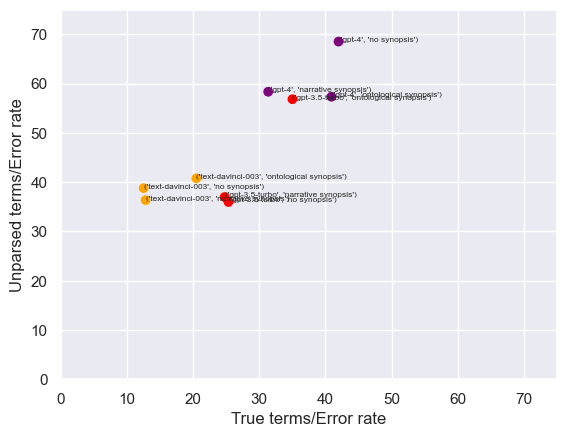

In [107]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df_plot = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df_plot = agg_df_plot.query(f"method in @METHOD")


print(qcols)
agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot= agg_df_plot.query(f"method != '{x}'")
    
print(agg_df_plot.shape)
print("cols")
print(agg_df_plot.columns)

print("index")
print(agg_df_plot.index)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']
#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3
#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

ax.scatter(xs,ys,
           c=colors)
#, label=agg_df.index

for i in range(0,len(xs)):
    ax.annotate(agg_df_plot.index[i], (xs[i], ys[i]))
    
ax.set_xlabel("True terms/Error rate")
ax.set_ylabel("Unparsed terms/Error rate")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,75)
plt.ylim(0,75)

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Core subsets

Copy this to [subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=669935942)

In [108]:
subsets_cols =  [MODEL, METHOD, "goslim_generic", "anc_of_goslim_generic", "goslim_agr", "anc_of_goslim_agr"]
subsets_grouped = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols]
means = subsets_grouped.mean(numeric_only=True)
means["closure_of_goslim_generic"] = means["goslim_generic"] + means["anc_of_goslim_generic"]
means["closure_of_goslim_agr"] = means["goslim_agr"] + means["anc_of_goslim_agr"]
means.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### TABLE: Above the shoreline in key subsets

[anc subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=345667144)

In [109]:
sorted_means = means.sort_values("anc_of_goslim_generic", ascending=False)
filtered = sorted_means[["anc_of_goslim_generic", "anc_of_goslim_agr"]]
filtered.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [110]:
means[["anc_of_goslim_generic", "anc_of_goslim_agr"]].sort_values("anc_of_goslim_agr", ascending=True).style.highlight_min(axis=0, props='font-weight:bold').format(precision=3)

In [111]:
# Reset the index of the pivoted DataFrame to have 'profession' as a column
#subsets_df = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols].mean(numeric_only=True).reset_index()

# Melt the DataFrame to have 'category', 'profession', and 'percentage' columns
#melted_df = subsets_df.melt(id_vars=[MODEL, METHOD], var_name='subset', value_name='proportion')
#melted_df["mm"] = melted_df[MODEL] + melted_df[METHOD]
#melted_df
# Create a bar plot using Seaborn
#plt.figure(figsize=(10, 6))
#sns.barplot(x='subset', y='proportion', hue="mm", data=melted_df)
#plt.title('Subsets by method')
#plt.xlabel('Subset')
#plt.ylabel('Proportion')
#plt.legend(title='Subsets')
#plt.show()

## Evaluation

In [112]:
agg_table(df, [NUM_GO_TERMS, SIZE_OVERLAP, NR_SIZE_OVERLAP], ["standard"])

In [113]:
eval_summary_cols = [HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NUM_GO_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY, MEAN_P_VALUE, MIN_P_VALUE, MAX_P_VALUE, PROPOTION_SIGNIFICANT, NUM_NOVEL]
agg_table(df, eval_summary_cols)

## as above, no perturbation

In [114]:
df_no_perturb = df.query(f"{GENE_RANDOMIZATION_FACTOR} == 0")
agg_table(df_no_perturb, CORE_METRICS, EXCLUDE)


## Maximums

In [115]:
df[[MODEL, METHOD] + eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


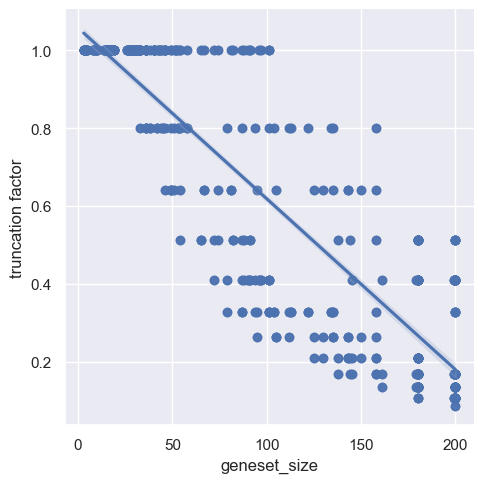

In [116]:

sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/py

<Axes: xlabel='geneset_size', ylabel='truncation factor'>

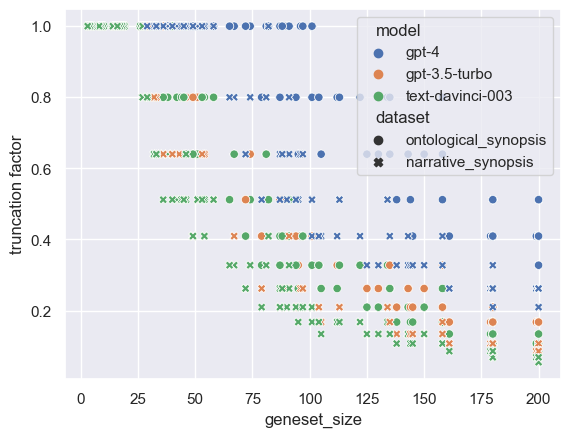

In [117]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [118]:
df.query(f"{GENESET_SIZE} < 50")[[SOURCE_GENESET]].drop_duplicates()

source geneset
0                             glycolysis-gocam
184                                        EDS
414                                 peroxisome
506                      HALLMARK_ANGIOGENESIS
552       go-postsynapse-calcium-transmembrane
...                                        ...
2898              HALLMARK_PANCREAS_BETA_CELLS
2944                     go-reg-autophagy-pkra
2990                   HALLMARK_APICAL_SURFACE
3036  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY
3082               HALLMARK_HEDGEHOG_SIGNALING

[25 rows x 1 columns]

In [119]:
df_small = df.query(f"{GENESET_SIZE} < 50")
means = df_small[[MODEL, METHOD] + eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has top term  in top 5  in top 10  \
model            method                                                    
N/A              closure                       1.00      0.00       0.00   
                 random                        0.00      0.00       0.00   
                 rank_based                    0.02      0.00       0.00   
                 standard                      1.00      1.00       1.00   
                 standard_no_ontology          0.61      0.57       0.57   
...                                             ...       ...        ...   
gpt-4            no_synopsis                   0.15      0.15       0.15   
                 ontological_synopsis          0.32      0.30       0.32   
text-davinci-003 narrative_synopsis            0.10      0.10       0.10   
                 no_synopsis                   0.10      0.10       0.10   
                 ontological_synopsis          0.17      0.12       0.15   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              closure                     129.11    7.86e-02    2363.85   
                 random                        1.28    6.60e-03      25.74   
                 rank_based                    2.96    1.92e-02      26.72   
                 standard                    129.11    9.83e-01     132.04   
                 standard_no_ontology         28.76    2.18e-01      38.46   
...                                             ...         ...        ...   
gpt-4            no_synopsis                   1.98    2.09e-02       5.95   
                 ontological_synopsis          2.86    3.40e-02       7.45   
text-davinci-003 narrative_synopsis            1.28    1.02e-02      11.63   
                 no_synopsis                   0.91    9.32e-03       7.50   
                 ontological_synopsis          2.08    1.85e-02      11.95   

                                       num GO terms  nr size overlap  \
model            method                                                
N/A              closure                    2321.15             4.67   
                 random                       25.74             0.24   
                 rank_based                   26.72             0.35   
                 standard                    129.11            16.85   
                 standard_no_ontology         38.46             5.78   
...                                             ...              ...   
gpt-4            no_synopsis                   3.32             0.65   
                 ontological_synopsis          5.54             0.88   
text-davinci-003 narrative_synopsis            3.65             0.39   
                 no_synopsis                   2.70             0.25   
                 ontological_synopsis          7.08             0.52   

                                       nr similarity  mean p value  \
model            method                                              
N/A              closure                    2.19e-02      9.16e-01   
                 random                     6.17e-03      9.59e-01   
                 rank_based                 1.07e-02      9.05e-01   
                 standard                   9.80e-01      8.31e-03   
                 standard_no_ontology       1.87e-01      2.94e-01   
...                                              ...           ...   
gpt-4            no_synopsis                4.07e-02      4.01e-01   
                 ontological_synopsis       5.14e-02      4.79e-01   
text-davinci-003 narrative_synopsis         1.79e-02      6.81e-01   
                 no_synopsis                1.69e-02      6.22e-01   
                 ontological_synopsis       2.71e-02      6.81e-01   

                                       min p value  max p value  \
model            method                                           
N/A              closure                  2.89e-06   

In [120]:
def color_lightness(rgb, lightness_scale):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * lightness_scale), s = s)

In [121]:

agg_df_plot = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot = agg_df_plot.query(f"method != '{x}'")    
    
agg_df_small_plot = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot = agg_df_small_plot.query(f"method != '{x}'")
    
agg_df_plot_std = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_plot_std = agg_df_plot_std.query(f"method != '{x}'")    
    
agg_df_small_plot_std = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).std(numeric_only=True)
for x in EXCLUDE:
    #print(x)
    agg_df_small_plot_std = agg_df_small_plot_std.query(f"method != '{x}'")


print(agg_df_small_plot.shape)
print("cols")
print(agg_df_small_plot.columns)

print("index")
print(agg_df_small_plot.index)


(9, 5)
cols
Index(['proportion significant', 'has top term', 'num GO terms',
       'num unannotated', 'num unparsed'],
      dtype='object')
index
MultiIndex([(   'gpt-3.5-turbo',   'narrative synopsis'),
            (   'gpt-3.5-turbo',          'no synopsis'),
            (   'gpt-3.5-turbo', 'ontological synopsis'),
            (           'gpt-4',   'narrative synopsis'),
            (           'gpt-4',          'no synopsis'),
            (           'gpt-4', 'ontological synopsis'),
            ('text-davinci-003',   'narrative synopsis'),
            ('text-davinci-003',          'no synopsis'),
            ('text-davinci-003', 'ontological synopsis')],
           names=['model', 'method'])


method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
model             method              
gpt-3.5-turbo     narrative synopsis      24.75
                  no synopsis             25.33
                  ontological synopsis    35.00
gpt-4             narrative synopsis      31.33
                  no synopsis             41.97
                  ontological synopsis    40.90
text-davinci-003  narrative synopsis      12.80
                  no synopsis             12.51
                  ontological synopsis    20.48
dtype: float64
['red', 'red', 'red', 'purple', 'purple', 'purple', 'orange', 'orange', 'orange']
[(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]
{'o', 's', '^'}
['o', '^', 's', 'o', '^', 's', 'o', '^', 's

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1909417184.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1909417184.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1909417184.py:101: FutureWarning: Series.__getitem__ treating keys as position

<Figure size 600x600 with 0 Axes>

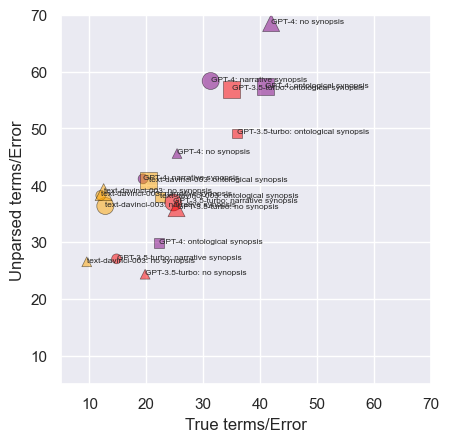

In [122]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['num GO terms']/agg_df_plot['num unannotated']
ys = agg_df_plot['num unparsed']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['num GO terms']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['num unparsed']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("True terms/Error")
ax.set_ylabel("Unparsed terms/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(5,70)
plt.ylim(5,70)
plt.gca().set_aspect("equal")

plt.savefig("true_vs_unparsed_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
model             method              
gpt-3.5-turbo     narrative synopsis      0.95
                  no synopsis             1.04
                  ontological synopsis    1.52
gpt-4             narrative synopsis      0.82
                  no synopsis             1.29
                  ontological synopsis    1.21
text-davinci-003  narrative synopsis      0.27
                  no synopsis             0.29
                  ontological synopsis    0.29
dtype: float64
model             method              
gpt-3.5-turbo     narrative synopsis      4.21
                  no synopsis             3.39
                  ontological synopsis    6.10
gpt-4             narrative synopsis      4.37
                  no synopsis             5.98
                  ontological synopsis    4.43
text-davinci-003  narrative synopsis      1.11
                  no synopsis      

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1515409393.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1515409393.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1515409393.py:108: FutureWarning: Series.__getitem__ treating keys as position

<Figure size 600x600 with 0 Axes>

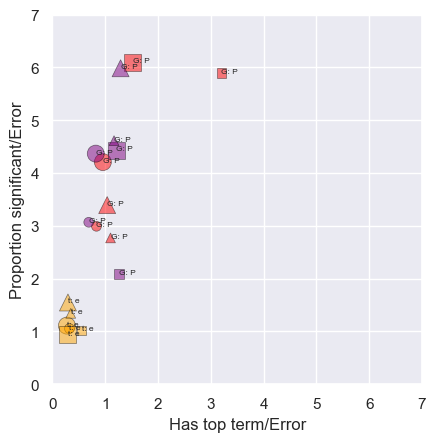

In [123]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']/agg_df_plot['num unannotated']
ys = agg_df_plot['proportion significant']/agg_df_plot['num unannotated']

xs_small = agg_df_small_plot['has top term']/agg_df_small_plot['num unannotated']
ys_small = agg_df_small_plot['proportion significant']/agg_df_small_plot['num unannotated']

#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term/Error")
ax.set_ylabel("Proportion significant/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,7)
plt.ylim(0,7)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_vs_error.pdf", format="pdf", bbox_inches="tight")

plt.show()

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
(3266, 7)
['red', 'red', 'red', 'purple', 'purple', 'purple', 'orange', 'orange', 'orange']
[(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]
{'o', 's', '^'}
['o', '^', 's', 'o', '^', 's', 'o', '^', 's']


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1886383008.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1886383008.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1886383008.py:128: FutureWarning: Series.__getitem__ treating keys as positi

<Figure size 600x600 with 0 Axes>

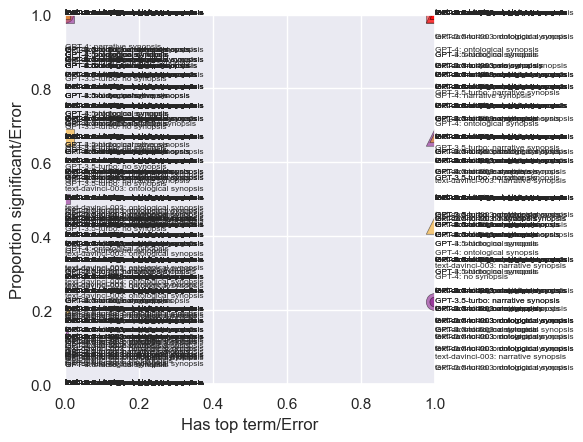

In [124]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

agg_df_plot_all = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])

#pd.concat(map(lambda x: x[1], groups)).sort_index(
agg_df_plot_all = agg_df_plot_all.apply(lambda x: x)
#
#agg_df_plot_all = agg_df_plot_all.head(1000000)

print(agg_df_plot_all.shape)
type(agg_df_plot_all)
#print(agg_df_plot_all.iloc[:200])
for x in EXCLUDE:
    #print(x)
    agg_df_plot_all = agg_df_plot_all.query(f"method != '{x}'")    
    
agg_df_small_plot_all = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD])
agg_df_small_plot_all = agg_df_small_plot_all.apply(lambda x: x)

for x in EXCLUDE:
    #print(x)
    agg_df_small_plot_all = agg_df_small_plot_all.query(f"method != '{x}'")
    
newindex = agg_df_plot_all.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])
#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot_all['has top term']
ys = agg_df_plot_all['proportion significant']

xs_small = agg_df_small_plot_all['has top term']
ys_small = agg_df_small_plot_all['proportion significant']

#print(agg_df.index)

#print(xs)
#print(ys)
#print(np.max(xs))
#print(np.max(ys))
#print(np.max(xs_small))
#print(np.max(ys_small))


#yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    #print(mask)
    #print(type(mask))
    #print(maskar)
    #print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    #print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    #print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot_all.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
for i in range(0,len(xs_small)):
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  

ax.set_xlabel("Has top term/Error")
ax.set_ylabel("Proportion significant/Error")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion__individual.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [125]:
df.columns
#num GO terms = TP
#num unannotated = FP
#num terms
#num unparsed

Index(['model', 'method', 'geneset', 'truncation factor', 'prompt_variant',
       'summary', 'source geneset', 'gene_randomization_factor',
       'has top term', 'rank', 'in top 5', 'in top 10', 'size overlap',
       'nr size overlap', 'similarity', 'nr similarity', 'number_of_terms',
       'num GO terms', 'geneset_size', 'term ids', 'term_strings',
       'go term ids', 'num terms', 'num unparsed', 'unparsed',
       'go term p values', 'max p value', 'min p value', 'mean p value',
       'proportion significant', 'unannotated', 'unannotated labels',
       'num unannotated',
       'number of true positives across a set of gene GO annotations',
       'number of false positives across a set of gene GO annotations',
       'true positive rate across a set of gene GO annotations',
       'false positive rate across a set of gene GO annotations'],
      dtype='object')

method
['model', 'method', 'false positive rate across a set of gene GO annotations', 'true positive rate across a set of gene GO annotations']
(14, 2)
Index(['false positive rate across a set of gene GO annotations', 'true positive rate across a set of gene GO annotations'], dtype='object')
['red', 'red', 'red', 'purple', 'purple', 'purple', 'orange', 'orange', 'orange']
[(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 0.0039215686274509665, 0.9999999999999998), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]
{'o', 's', '^'}
['o', '^', 's', 'o', '^', 's', 'o', '^', 's']


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/940145597.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/940145597.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/940145597.py:85: FutureWarning: Se

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

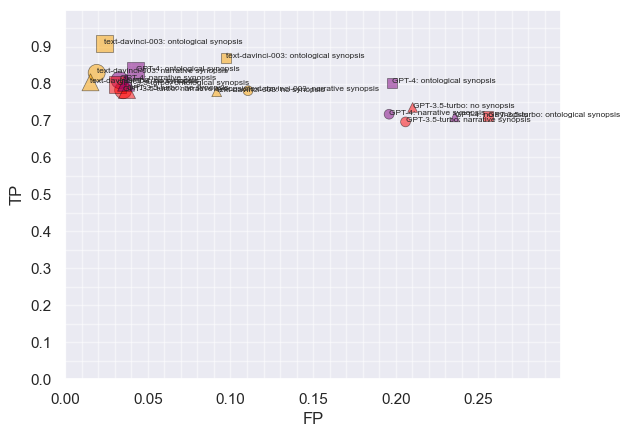

In [183]:
CORE_METRICS2 = [FP, TP]
qcols = [MODEL, METHOD] + CORE_METRICS2

print(METHOD)
print(qcols)

agg_df_plot_tpfp = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)

agg_df_plot_tpfp = agg_df_plot_tpfp.apply(lambda x: x)

print(agg_df_plot_tpfp.shape)
type(agg_df_plot_tpfp)
for x in EXCLUDE:
    agg_df_plot_tpfp = agg_df_plot_tpfp.query(f"method != '{x}'")    

print(agg_df_small_plot_tpfp.columns)

agg_df_small_plot_tpfp = df_small.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
agg_df_small_plot_tpfp = agg_df_small_plot_tpfp.apply(lambda x: x)

for x in EXCLUDE:
    agg_df_small_plot_tpfp = agg_df_small_plot_tpfp.query(f"method != '{x}'")
    
newindex = agg_df_plot_tpfp.index

xs = agg_df_plot_tpfp['true positive rate across a set of gene GO annotations']
ys = agg_df_plot_tpfp['false positive rate across a set of gene GO annotations']

xs_small = agg_df_small_plot_tpfp['true positive rate across a set of gene GO annotations']
ys_small = agg_df_small_plot_tpfp['false positive rate across a set of gene GO annotations']

reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3

colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3

markers = [*circles]

SMALL_SIZE = 6
plt.figure()
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    mask = [index for index, elem in enumerate(markers) if elem == um]
    maskar = np.array(mask)
    minv = mask[0]
    maxv = mask[2]
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)#, marker=um#, c=nowcol
    
agg_df_plot_labels = agg_df_plot_tpfp.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
for i in range(0,len(xs_small)):
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  


# Major ticks every 20, minor ticks every 5
xmajor_ticks = np.arange(0, 0.3, 0.05)
xminor_ticks = np.arange(0, 0.3, 0.01)
ymajor_ticks = np.arange(0, 1, 0.1)
yminor_ticks = np.arange(0, 1, 0.05)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.5)
ax.grid(which='major', alpha=0.5)
#ax.grid(color="blue")


ax.set_xlabel("FP")
ax.set_ylabel("TP")

plt.xlim(0,0.3)
plt.ylim(0,1)
#plt.gca().set_aspect("equal")

plt.savefig("TP_vs_FP.pdf", format="pdf", bbox_inches="tight")

plt.show()

method
['model', 'method', 'proportion significant', 'has top term', 'num GO terms', 'num unannotated', 'num unparsed']
model             method              
gpt-3.5-turbo     narrative synopsis      0.15
                  no synopsis             0.20
                  ontological synopsis    0.15
gpt-4             narrative synopsis      0.11
                  no synopsis             0.14
                  ontological synopsis    0.17
text-davinci-003  narrative synopsis      0.09
                  no synopsis             0.08
                  ontological synopsis    0.10
Name: has top term, dtype: float64
model             method              
gpt-3.5-turbo     narrative synopsis      0.65
                  no synopsis             0.66
                  ontological synopsis    0.62
gpt-4             narrative synopsis      0.60
                  no synopsis             0.65
                  ontological synopsis    0.61
text-davinci-003  narrative synopsis      0.37
               

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1366996683.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1366996683.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1366996683.py:104: FutureWarning: Series.__getitem__ treating keys as positi

<Figure size 600x600 with 0 Axes>

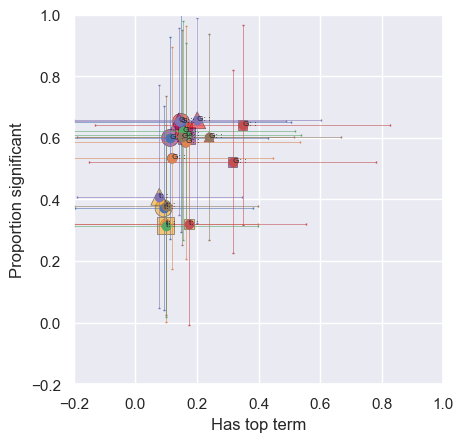

In [168]:

qcols = [MODEL, METHOD] + CORE_METRICS

print(METHOD)
#agg_df_orig = df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
#agg_df = pd.DataFrame( columns=agg_df_orig.columns)#NULL#pd.DataFrame() 
#print(EXCLUDE)
#agg_df = agg_df_orig.query(f"method in @METHOD")

print(qcols)

newindex = agg_df_plot.index
#len = agg_df.index.to_flat_index().size()
#print(len)
#for i in range(1,len):
#    newindex[i] = agg_df.index[i]

#print(agg_df.loc[:, 'model'])

#print(agg_df['num GO terms'])

#rework for significant GO terms
xs = agg_df_plot['has top term']
ys = agg_df_plot['proportion significant']
xs_er = agg_df_plot_std['has top term']
ys_er = agg_df_plot_std['proportion significant']

xs_small = agg_df_small_plot['has top term']
ys_small = agg_df_small_plot['proportion significant']
xs_small_er = agg_df_small_plot_std['has top term']
ys_small_er = agg_df_small_plot_std['proportion significant']


#print(agg_df.index)

print(xs)
print(ys)
print(np.max(xs))
print(np.max(ys))
print(np.max(xs_small))
print(np.max(ys_small))


yells = ["yellow"]*5
reds = ["red"] *3
purps = ["purple"] *3
orans = ["orange"]*3

colorr = mpl.colors.ColorConverter.to_rgb("red")
rgbr = [color_lightness(colorr, scale) for scale in [2]]
colorp = mpl.colors.ColorConverter.to_rgb("purple")
rgbp = [color_lightness(colorp, scale) for scale in [2]]
coloro = mpl.colors.ColorConverter.to_rgb("orange")
rgbo = [color_lightness(coloro, scale) for scale in [2]]

redss = rgbr *3
purpss = rgbp *3
oranss = rgbo *3


#colors = [*yells, *reds, *purps, *orans]
colors = [*reds, *purps, *orans]
print(colors)

colors_small = [*redss, *purpss, *oranss]
print(colors_small)

circles= ['o','^','s']*3
#triangles= ['^']*3
#squares= ['s']*3

markers = [*circles]#, *triangles, *squares]

SMALL_SIZE = 6
plt.rc('font', size=SMALL_SIZE)   
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()

#ax.scatter(xs,ys, c=colors, s=50, marker=marker)
#ax.scatter(xs_small,xs_small, c=colors, s=25, marker=marker)

unique_markers = set(markers)
print(unique_markers)
print(markers)

for um in unique_markers:
    #print(um)
    #print(markers.index(um))    
    #print([index for index, elem in enumerate(markers) if elem == um])
    mask = [index for index, elem in enumerate(markers) if elem == um]# markers == um
    maskar = np.array(mask)
    print(mask)
    print(type(mask))
    print(maskar)
    print(type(maskar))
    minv = mask[0]
    maxv = mask[2]
    print(str(minv)+"\t"+str(maxv))
    nowcol = [colors[mask[0]], colors[mask[1]], colors[mask[2]]]
    print(nowcol)
    
    ax.scatter(xs[mask], ys[mask], marker=um, c=nowcol, s=150, alpha=0.5, edgecolors="black",  linewidth=0.5)
    ax.scatter(xs_small[mask], ys_small[mask], marker=um, c=nowcol, s=50, alpha=0.5, edgecolors="black",  linewidth=0.5)

    ax.errorbar(xs[mask], ys[mask], xerr= xs_er[mask], yerr=ys_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)# ecolor=nowcol,
    ax.errorbar(xs_small[mask], ys_small[mask], xerr= xs_small_er[mask], yerr=ys_small_er[mask], fmt="o", elinewidth=0.4, capsize=0.4)
    
#, label=agg_df.index
agg_df_plot_labels = agg_df_plot.index.values
for i in range(0, len(xs)):
    agg_df_plot_labels[i] = (agg_df_plot_labels[i][0] + ": " + agg_df_plot_labels[i][1]).replace("(","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(")","")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace(" - "," : ")
    agg_df_plot_labels[i] = agg_df_plot_labels[i].replace("gpt","GPT")        
                
for i in range(0,len(xs)):
    ax.annotate(agg_df_plot_labels[i], (xs[i], ys[i]))
    ax.annotate(agg_df_plot_labels[i], (xs_small[i], ys_small[i]))  
ax.set_xlabel("Has top term")
ax.set_ylabel("Proportion significant")

#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper left')

plt.xlim(-0.2,1)
plt.ylim(-0.2,1)
plt.gca().set_aspect("equal")

plt.savefig("top_vs_proportion_std.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## TABLE: evaluation for gene sets < 75

In [ ]:
agg_table(df_small, CORE_METRICS, EXCLUDE)

## Looking at individual gene sets

In [ ]:

def terms_summary(df, variant="v1", max_rows=9999):
    term_dict = {}
    n = 0
    for _, row in df.iterrows():
        if row[PROMPT_VARIANT] and row[PROMPT_VARIANT] != variant:
            continue
        n += 1
        if n > max_rows:
            break
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = str(row['method']).replace('_', ' ')
        if method in ["closure", "rank_based", "random"]:
            continue
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

In [ ]:
import oaklib.datamodels.obograph as og
from oaklib.utilities.obograph_utils import graph_to_image, default_stylemap_path
!mkdir -p output

MMAP = {"standard": None, 
        "gpt-3.5-turbo.no_synopsis": "NS",
        "gpt-3.5-turbo.ontological_synopsis": "ONT",
        "gpt-3.5-turbo.narrative_synopsis": "NAR",
       }

def viz(geneset, include_std=True, mmap = MMAP, variant="v1"):
    methods = mmap.keys()
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    terms = set()
    terms.add("GO:0008150")
    terms.add("GO:0003674")
    terms.add("GO:0005575")
    m2t = defaultdict(list)
    t2m = defaultdict(set)
    seeds = []
    for m in methods:
        if m == "standard":
            mv = m
        else:
            mv = f"{m}.{variant}"
        p = gsobj.payloads[mv]
        if include_std or m != "standard":
            terms.update(p.term_ids)
        for t in p.term_ids:
            if t.startswith("MONDO:"):
                continue
            m2t[m].append(t)
            t2m[t].add(m)
            if m == "standard":
                seeds.append(t)
    # rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF, "RO:0002211", "RO:0002212", RO:0002213"])
    rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF])
    g = go.relationships_to_graph(rels)
    for n in g.nodes:
        if not n.lbl:
            n.lbl = go.label(n.id)
        if not n.lbl:
            n.lbl = n.id
        if n.id in t2p:
            n.lbl += f" {t2p[n.id]:.2e}"
        #for m in t2m[n.id]:
        #    n.lbl += f" [<b>{m}</b>]"
    for m in m2t.keys():
        if m == "standard":
            continue
        for t in m2t[m]:
            n = og.Node(id=f"{mmap[m]}:{t}", lbl=mmap[m])
            g.nodes.append(n)
            g.edges.append(og.Edge(n.id, "has", t))
    outfile = f"output/{geneset.replace(' ', '_')}-{include_std}-{variant}.png"
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="conf/enr-style.json")
    #return g
    
viz('peroxisome-0')
viz('peroxisome-0', variant="v2")

In [ ]:
def geneset_summary(df, geneset):
    sdf = terms_summary(df.query(f"{GENESET} == '{geneset}'").sort_values("similarity", ascending=False))
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    sdf["p_label"] = sdf.apply(lambda row: str(row.label) + " " + str(t2p.get(row.id, "")), axis=1)
    return sdf

geneset_summary(df, 'peroxisome-0')

### Peroxisome

In [ ]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

In [ ]:
terms_summary(peroxisome, "v2")

## Sensory Ataxia

In [ ]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[[MODEL, METHOD] + eval_summary_cols]                                                  

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [ ]:
ataxia[[MODEL, METHOD, PROMPT_VARIANT, GO_TERM_IDS, NOVEL_LABELS]]

In [ ]:
viz('sensory ataxia-0')

![img](output/sensory_ataxia-0-True-v1.png)

In [ ]:
viz('sensory ataxia-0', variant="v2")

![img](output/sensory_ataxia-0-True-v2.png)

In [127]:
terms_summary(ataxia)

id                                  label  \
0                   GO:0042552                            myelination   
1                   GO:0008366                      axon ensheathment   
2                   GO:0007272                ensheathment of neurons   
3                   GO:0007422  peripheral nervous system development   
4                   GO:0014037           Schwann cell differentiation   
..                         ...                                    ...   
69                  GO:0005737                              cytoplasm   
70                  GO:0033554            cellular response to stress   
71                  GO:0046907                intracellular transport   
72  dna repair and replication                                   None   
73                  GO:0050801             monoatomic ion homeostasis   

    redundant   standard  turbo ontological synopsis   ontological synopsis  \
0       False        0.0                         0.0                    8.0   
1        True        1.0                         NaN                    NaN   
2        True        2.0                         NaN                    NaN   
3       False        3.0                         1.0                    NaN   
4        True        4.0                         NaN                    NaN   
..        ...        ...                         ...                    ...   
69      False        NaN                         NaN                    NaN   
70      False        NaN                         NaN                    NaN   
71      False        NaN                         NaN                    NaN   
72      False        NaN                         NaN                    NaN   
73      False        NaN                         NaN                    NaN   

     standard no ontology  turbo narrative synopsis   narrative synopsis  \
0                     NaN                       NaN                  NaN   
1                     NaN                       NaN                  NaN   
2                     NaN                       NaN                  NaN   
3                     3.0                       NaN                  NaN   
4                     NaN                       NaN                  NaN   
..                    ...                       ...                  ...   
69                    NaN                       NaN                  NaN   
70                    NaN                       NaN                  NaN   
71                    NaN                       NaN                  NaN   
72                    NaN                       NaN                  NaN   
73                    NaN                       NaN                  NaN   

    dav ontological synopsis   no synopsis  dav no synopsis   rank based  \
0                        NaN           NaN              NaN          NaN   
1                        NaN           NaN              NaN          NaN   
2                        NaN           NaN              NaN          NaN   
3                        NaN           NaN              NaN          NaN   
4                        NaN           NaN              NaN          NaN   
..                       ...           ...              ...          ...   
69                       NaN           NaN              NaN         14.0   
70                       NaN           1.0              NaN          NaN   
71                       NaN           2.0              NaN          NaN   
72                       NaN           5.0              NaN          NaN   
73                       NaN           6.0              NaN          NaN   

    dav narrative synopsis  turbo no synopsis  
0                      NaN                NaN  
1                      NaN                NaN  
2                      NaN                NaN  
3                      NaN                NaN  
4                      NaN                NaN  
..                     ...                ...  
69                     NaN              

In [128]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [129]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis.v1").response_text)

Summary: Genes are primarily involved in the peripheral nervous system, myelination, and neurological disorders.
Mechanism: The enriched terms suggest that these genes primarily function in the peripheral nervous system and myelination.
Enriched Terms:  myelination; peripheral nervous system development; neurological disorder; peripheral nervous system myelination; and neuropathy. 
Hypothesis: These genes are all involved in the development and maintenance of the peripheral nervous system and myelination. Dysregulation or mutation of these genes likely leads to neuropathic disorders.


In [130]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

Summary: Myelin upkeep and neurological diseases
Enriched Terms: Charcot-Marie-Tooth disease; peripheral neuropathy; Dejerine-Sottas syndrome; myelin sheath; mitochondrial DNA replication; tetratricopeptide repeat; transporter protein

Mechanism: These genes are involved in myelin upkeep and various neurological diseases associated with defects in myelin sheath synthesis and functions. They play roles in mitochondrial DNA replication and transport, as well as protein transportation across the nuclear membrane. The presence of tetratricopeptide repeat motifs in these genes suggests their roles in protein-protein interactions and chaperone functions.

Hypothesis: Dysregulation of the myelin upkeep pathways can lead to mitochondrial dysfunction, accumulations of toxic metabolites, and impaired protein processing, which contribute to the development of neurological diseases. Dysfunction of the transporter proteins and nuclear membrane transporters can further exacerbate cell dysfunction an

In [131]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis.v1").response_text)

Summary: The enriched terms found among the listed human genes suggest a common involvement in cellular metabolism, particularly in mitochondrial function, protein folding and degradation, and transportation across cellular membranes.
Mechanism: These genes may be involved in the maintenance of cellular homeostasis and energy production.
Enriched Terms: Mitochondrial function; Protein folding; Protein degradation; Membrane transport. 

Hypothesis: Many of the enriched terms are related to cellular stress pathways, suggesting that these genes may be involved in the response to stress and cellular damage. Additionally, the involvement of several genes related to mitochondrial function suggests that there may be a common underlying mechanism related to energy production and metabolism.


## T cell proliferation

In [132]:
tcp = df.query(f"{GENESET} == 'T cell proliferation-0'").sort_values("similarity", ascending=False)
tcp[[MODEL, METHOD] + eval_summary_cols]

model                method  has top term  in top 5  \
3146               N/A              standard          True      True   
3147               N/A  standard_no_ontology          True      True   
3150               N/A               closure          True     False   
3149               N/A            rank_based         False     False   
3136     gpt-3.5-turbo  ontological_synopsis         False     False   
...                ...                   ...           ...       ...   
3134     gpt-3.5-turbo           no_synopsis         False     False   
3142  text-davinci-003  ontological_synopsis         False     False   
3145  text-davinci-003    narrative_synopsis         False     False   
3144  text-davinci-003    narrative_synopsis         False     False   
3139     gpt-3.5-turbo    narrative_synopsis         False     False   

      in top 10  size overlap  similarity  num terms  num GO terms  \
3146       True           491    1.00e+00        491           491   
3147       True            79    1.56e-01         95            95   
3150      False           491    1.11e-01       6315          6255   
3149      False            15    2.74e-02         72            72   
3136      False             5    1.02e-02          8             5   
...         ...           ...         ...        ...           ...   
3134      False             1    2.04e-03          3             1   
3142      False             1    2.02e-03          6             4   
3145      False             0    0.00e+00         17             0   
3144      False             0    0.00e+00         10             6   
3139      False             0    0.00e+00          9             4   

      nr size overlap  nr similarity  mean p value  min p value  max p value  \
3146               17       1.00e+00      2.96e-03    2.66e-193     4.96e-02   
3147                3       4.48e-02      1.71e-01    2.66e-193     1.00e+00   
3150                4       6.19e-03      8.93e-01    2.66e-193     1.00e+00   
3149                0       0.00e+00      7.92e-01     3.40e-19     1.00e+00   
3136                0       0.00e+00      1.08e-02     1.22e-28     4.94e-02   
...               ...            ...           ...          ...          ...   
3134                0       0.00e+00     4.13e-126    4.13e-126    4.13e-126   
3142                0       0.00e+00      7.50e-01     8.79e-09     1.00e+00   
3145                0       0.00e+00           NaN          NaN          NaN   
3144                0       0.00e+00      1.00e+00     1.00e+00     1.00e+00   
3139                0       0.00e+00      1.00e+00     1.00e+00     1.00e+00   

      proportion significant  num unannotated  
3146                    1.00                0  
3147                    0.83                0  
3150                    0.11                0  
3149                    0.21                4  
3136                    1.00                0  
...                      ...              ...  
3134                    1.00                0  
3142                    0.25                0  
3145                     NaN                0  
3144                    0.00                0  
3139                    0.00                2  

[23 rows x 16 columns]

In [133]:
viz('T cell proliferation-0')

![img](output/T_cell_proliferation-0-True-v1.png)

In [134]:
terms_summary(tcp)

id  \
0                              GO:0042098   
1                              GO:0046651   
2                              GO:0032943   
3                              GO:0070661   
4                              GO:0042110   
..                                    ...   
596                            GO:0004721   
597                            GO:0004725   
598                          MESH:D015533   
599  guanine nucleotide exchange activity   
600               ligand binding activity   

                                     label  redundant   standard  \
0                     T cell proliferation      False        0.0   
1                 lymphocyte proliferation       True        1.0   
2           mononuclear cell proliferation       True        2.0   
3                  leukocyte proliferation       True        3.0   
4                        T cell activation       True        4.0   
..                                     ...        ...        ...   
596    phosphoprotein phosphatase activity      False        NaN   
597  protein tyrosine phosphatase activity      False        NaN   
598                                   None      False        NaN   
599                                   None      False        NaN   
600                                   None      False        NaN   

      standard no ontology   ontological synopsis   no synopsis  \
0                      0.0                    NaN           NaN   
1                      NaN                    NaN           NaN   
2                      NaN                    NaN           NaN   
3                      NaN                    NaN           NaN   
4                     12.0                    4.0           0.0   
..                     ...                    ...           ...   
596                    NaN                    NaN           NaN   
597                    NaN                    NaN           NaN   
598                    NaN                    NaN           NaN   
599                    NaN                    NaN           NaN   
600                    NaN                    NaN           NaN   

     turbo no synopsis  turbo ontological synopsis   rank based  \
0                  NaN                         NaN          NaN   
1                  NaN                         NaN          NaN   
2                  NaN                         NaN          NaN   
3                  NaN                         NaN          NaN   
4                  2.0                         NaN          NaN   
..                 ...                         ...          ...   
596                NaN                         NaN          NaN   
597                NaN                         NaN          NaN   
598                NaN                         NaN          NaN   
599                NaN                         NaN          NaN   
600                NaN                         NaN          NaN   

     turbo narrative synopsis  dav no synopsis   narrative synopsis  \
0                         NaN              NaN                  NaN   
1                         NaN              NaN                  NaN   
2                         NaN              NaN                  NaN   
3                         NaN              NaN                  NaN   
4                         NaN              NaN                  NaN   
..                        ...              ...                  ...   
596                       NaN              NaN                  NaN   
597                       NaN              NaN                  NaN   
598                       NaN              NaN                  NaN   
599                       NaN              NaN                  NaN   
600                       NaN              NaN                  NaN   

     dav ontological synopsis  dav narrative synopsis  
0                         NaN                     NaN  
1                         NaN                     NaN  
2                         NaN                     

## Endocytosis

In [135]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

id                                             label  redundant  \
0    GO:0006907                                       pinocytosis      False   
1    GO:0006897                                       endocytosis       True   
2    GO:0044351                                  macropinocytosis       True   
3    GO:0016192                        vesicle-mediated transport       True   
4    GO:0030100                         regulation of endocytosis      False   
..          ...                                               ...        ...   
113  GO:0006357  regulation of transcription by RNA polymerase II      False   
114  GO:0005634                                           nucleus      False   
115  GO:0005524                                       ATP binding      False   
116  GO:0005737                                         cytoplasm      False   
117  GO:0005576                              extracellular region      False   

      standard   standard no ontology  turbo ontological synopsis  \
0          0.0                    1.0                         NaN   
1          1.0                    6.0                         0.0   
2          2.0                    0.0                         NaN   
3          3.0                    NaN                         NaN   
4          4.0                    NaN                         NaN   
..         ...                    ...                         ...   
113        NaN                    NaN                         NaN   
114        NaN                    NaN                         NaN   
115        NaN                    NaN                         NaN   
116        NaN                    NaN                         NaN   
117        NaN                    NaN                         NaN   

     dav narrative synopsis  dav ontological synopsis   no synopsis  \
0                       NaN                       NaN           NaN   
1                       0.0                       5.0           1.0   
2                       4.0                       NaN           NaN   
3                       NaN                       NaN           2.0   
4                       NaN                       NaN           NaN   
..                      ...                       ...           ...   
113                     NaN                       NaN           NaN   
114                     NaN                       NaN           NaN   
115                     NaN                       NaN           NaN   
116                     NaN                       NaN           NaN   
117                     NaN                       NaN           NaN   

      narrative synopsis  turbo no synopsis  turbo narrative synopsis  \
0                    NaN                NaN                       NaN   
1                    1.0                0.0                       0.0   
2                    NaN                NaN                       NaN   
3                    NaN                1.0                       NaN   
4                    NaN                NaN                       NaN   
..                   ...                ...                       ...   
113                  NaN                NaN                       NaN   
114                  NaN                NaN                       NaN   
115                  NaN                NaN                       NaN   
116                  NaN                NaN                       NaN   
117                  NaN                NaN                       NaN   

      ontological synopsis  dav no synopsis   rank based  
0                      NaN              NaN          NaN  
1                      2.0              NaN          NaN  
2                      NaN              NaN          NaN  
3                      NaN              NaN          NaN  
4                      NaN              NaN          NaN  
..                     ...              ...          ...  
113                    NaN              NaN         11.0  
114                  

In [136]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").prompt)

I will give you a list of human genes  together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

For the list of terms, be sure to use a semi-colon separator, and do not number the list.
Always put the list of terms last, after mechanism, summary, or hypotheses.


Here are the gene summaries:


AHSG: The protein encoded by this gene is a negatively

In [137]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

Summary: Many of the genes in this list are involved in endocytosis, intracellular trafficking, and cytoskeleton reorganization.

Mechanism: These genes likely play a role in the regulation and maintenance of cellular processes by contributing to the turnover and recycling of molecules within the cell.

Enriched terms: endocytosis; intracellular trafficking; cytoskeleton reorganization.


In [138]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis.v1").prompt)

I will give you a list of human genes  together with descriptions of their functions.
Perform a term enrichment test on these genes.
i.e. tell me what the commonalities are in their function.
Make use of classification hierarchies when you do this.
Only report gene functions in common, not diseases.
e.g if gene1 is involved in "toe bone growth" and gene2 is involved in "finger morphogenesis"
then the term "digit development" would be enriched as represented by gene1 and gene2.
Only include terms that are statistically over-represented.
Also include a hypothesis of the underlying biological mechanism or pathway.

Provide results in the format

Summary: <high level summary>
Mechanism: <mechanism>
Enriched Terms: <term1>; <term2>; <term3>

For the list of terms, be sure to use a semi-colon separator, and do not number the list.
Always put the list of terms last, after mechanism, summary, or hypotheses.


Here are the gene summaries:


AHSG: Predicted to enable endopeptidase inhibitor acti

## Hydrolysis

In [139]:
hydrolysis = df.query(f"{GENESET} == 'hydrolase activity, hydrolyzing O-glycosyl compounds-0'").sort_values("similarity", ascending=False)
terms_summary(hydrolysis)

id  \
0                                                                                   GO:0004553   
1                                                                                   GO:0016798   
2                                                                                   GO:0005975   
3                                                                                   GO:0016787   
4                                                                                   GO:1901136   
..                                                                                         ...   
323  carbohydrate digestion and absorption; glycosaminoglycan and glycan metabolism; lysosomal   
324                                                                                 GO:0005777   
325                                                             and catabolic processes; digit   
326                                                                                   skeletal   
327                                                                                 GO:0035108   

                                                    label  redundant  \
0    hydrolase activity, hydrolyzing O-glycosyl compounds      False   
1            hydrolase activity, acting on glycosyl bonds       True   
2                          carbohydrate metabolic process      False   
3                                      hydrolase activity       True   
4               carbohydrate derivative catabolic process      False   
..                                                    ...        ...   
323                                                  None      False   
324                                            peroxisome      False   
325                                                  None      False   
326                                                  None      False   
327                                    limb morphogenesis      False   

      standard   standard no ontology  dav ontological synopsis  \
0          0.0                   62.0                      14.0   
1          1.0                    NaN                       NaN   
2          2.0                    0.0                       NaN   
3          3.0                    NaN                       NaN   
4          4.0                    NaN                       NaN   
..         ...                    ...                       ...   
323        NaN                    NaN                       NaN   
324        NaN                    NaN                       NaN   
325        NaN                    NaN                       NaN   
326        NaN                    NaN                       NaN   
327        NaN                    NaN                       NaN   

      narrative synopsis  dav narrative synopsis  turbo narrative synopsis  \
0                    NaN                     NaN                       NaN   
1                    1.0                     0.0                       NaN   
2                    0.0                     NaN                       2.0   
3                    7.0                     NaN                       3.0   
4                    NaN                     NaN                       NaN   
..                   ...                     ...                       ...   
323                  NaN                     NaN                       NaN   
324                  NaN                     NaN                       NaN   
325                  NaN                     NaN                       NaN   
326                  NaN                     NaN                       NaN   
327                  NaN                     NaN                       NaN   

     turbo no synopsis   no synopsis   ontological synopsis  \
0                  NaN           NaN                    NaN   
1                  NaN           NaN                    NaN   
2                  1.0           0.0                    NaN   
3                  NaN           NaN                    

In [140]:
viz('hydrolase activity, hydrolyzing O-glycosyl compounds-0')

![img](output/hydrolase_activity,_hydrolyzing_O-glycosyl_compounds-0-True-v1.png)

## Variability

In [141]:
pv_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=PROPOTION_SIGNIFICANT)
# Calculate differences between run "1" and run "2"
pv_pivot['diff'] = pv_pivot["v1"] - pv_pivot["v2"]
pv_pivot

prompt_variant                                                   v1    v2  \
model            method               geneset                               
gpt-3.5-turbo    narrative_synopsis   EDS-0                    0.14  0.50   
                                      EDS-1                    0.20  0.67   
                                      FA-0                     1.00  1.00   
                                      FA-1                     1.00  1.00   
                                      HALLMARK_ADIPOGENESIS-0  1.00  0.67   
...                                                             ...   ...   
text-davinci-003 ontological_synopsis sensory ataxia-1         0.09  0.12   
                                      term-GO:0007212-0        0.20  0.14   
                                      term-GO:0007212-1        0.25  1.00   
                                      tf-downreg-colorectal-0  0.57  0.33   
                                      tf-downreg-colorectal-1   NaN  0.80   

prompt_variant                                                 diff  
model            method               geneset                        
gpt-3.5-turbo    narrative_synopsis   EDS-0                   -0.36  
                                      EDS-1                   -0.47  
                                      FA-0                     0.00  
                                      FA-1                     0.00  
                                      HALLMARK_ADIPOGENESIS-0  0.33  
...                                                             ...  
text-davinci-003 ontological_synopsis sensory ataxia-1        -0.03  
                                      term-GO:0007212-0        0.06  
                                      term-GO:0007212-1       -0.75  
                                      tf-downreg-colorectal-0  0.24  
                                      tf-downreg-colorectal-1   NaN  

[1266 rows x 3 columns]

In [142]:

# Now you can perform statistics on the 'diff' column
df_diff_stats = pv_pivot['diff'].agg(['mean', 'std', 'var', 'min', 'max'])
df_diff_stats['range'] = df_diff_stats['max'] - df_diff_stats['min']
df_diff_stats

mean     4.41e-03
std      3.27e-01
var      1.07e-01
min     -1.00e+00
max      1.00e+00
range    2.00e+00
Name: diff, dtype: float64

In [143]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# pivot your dataframe as before
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=TERM_IDS, aggfunc=list)
df_pivot

prompt_variant                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               v1  \
model            method               geneset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
gpt-3.5-turbo    narrative_synopsis   EDS-0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [[GO:0032964, GO:0030198, GO:0010712, GO:0043687, GO:0006493, GO:0006508, GO:0008270]]   
                                      EDS-1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [[GO:0032964, GO:0061448, GO:0030198, GO:0006457, GO:0006508, transcriptional regulation]]   
                                      FA-0                                          

In [144]:

# calculate Jaccard index for each group
df_pivot['jaccard_index'] = df_pivot.apply(lambda row: jaccard_similarity(row["v1"][0], row["v2"][0]), axis=1)

# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

prompt_variant             model                method  \
0                  gpt-3.5-turbo    narrative_synopsis   
1                  gpt-3.5-turbo    narrative_synopsis   
2                  gpt-3.5-turbo    narrative_synopsis   
3                  gpt-3.5-turbo    narrative_synopsis   
4                  gpt-3.5-turbo    narrative_synopsis   
...                          ...                   ...   
1273            text-davinci-003  ontological_synopsis   
1274            text-davinci-003  ontological_synopsis   
1275            text-davinci-003  ontological_synopsis   
1276            text-davinci-003  ontological_synopsis   
1277            text-davinci-003  ontological_synopsis   

prompt_variant                  geneset  \
0                                 EDS-0   
1                                 EDS-1   
2                                  FA-0   
3                                  FA-1   
4               HALLMARK_ADIPOGENESIS-0   
...                                 ...   
1273                   sensory ataxia-1   
1274                  term-GO:0007212-0   
1275                  term-GO:0007212-1   
1276            tf-downreg-colorectal-0   
1277            tf-downreg-colorectal-1   

prompt_variant                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                v1  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [[GO:0032964, GO:0030198, GO:0010712, GO:0043687, GO:0006493, GO:0006508, GO:0008270]]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [[GO:0032964, GO:0061448, GO:0030198, GO:0006457, GO:0006508, transcriptional regula

In [145]:
result['jaccard_index'].describe()

count    1278.00
mean        0.13
std         0.14
min         0.00
25%         0.00
50%         0.10
75%         0.20
max         1.00
Name: jaccard_index, dtype: float64

In [146]:
result.groupby([MODEL])['jaccard_index'].describe()

count  mean   std  min   25%   50%   75%  max
model                                                          
gpt-3.5-turbo     426.0  0.14  0.15  0.0  0.00  0.11  0.20  0.8
gpt-4             426.0  0.19  0.15  0.0  0.08  0.17  0.25  1.0
text-davinci-003  426.0  0.06  0.07  0.0  0.00  0.04  0.08  0.5

In [147]:
result.groupby([MODEL, METHOD])['jaccard_index'].describe()[['count', 'mean', 'std', 'min', 'max']].style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [148]:
summaries = [s for s in list(df[SUMMARY]) if s]
len(summaries)
import random
def random_summary():
    return summaries[int(random.random() * len(summaries))]

random_summary()

'Summary: Involvement in lipid metabolism, transportation and detoxification, antioxidant defense, peroxisome function, and DNA repair.\nMechanism: These genes are likely involved in the regulation of cellular lipid homeostasis, detoxification of harmful substances, maintenance of redox balance, proper functioning of peroxisomes, and DNA repair processes to maintain genomic integrity.\n'

In [185]:
from ontogpt.clients import OpenAIClient

simclient = OpenAIClient(model="text-embedding-ada-002")

def text_similarity(text1, text2):
    return simclient.similarity(text1, text2)

text_similarity("nucleus of cell", "nuclear membrane")

0.8654903791519228

In [186]:
text_similarity(random_summary(), random_summary())

0.6894215668954194

In [187]:
rs = random_summary()
text_similarity(rs, rs)

0.9999999999999999

In [188]:
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=SUMMARY, aggfunc=list)
df_pivot

df_pivot['sim'] = df_pivot.apply(lambda row: text_similarity(row["v1"][0], row["v2"][0]), axis=1)
df_pivot['length_diff'] = df_pivot.apply(lambda row: abs(len(row["v1"][0])-len(row["v2"][0])), axis=1)


# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

prompt_variant             model                method  \
0                  gpt-3.5-turbo    narrative_synopsis   
1                  gpt-3.5-turbo    narrative_synopsis   
2                  gpt-3.5-turbo    narrative_synopsis   
3                  gpt-3.5-turbo    narrative_synopsis   
4                  gpt-3.5-turbo    narrative_synopsis   
...                          ...                   ...   
1273            text-davinci-003  ontological_synopsis   
1274            text-davinci-003  ontological_synopsis   
1275            text-davinci-003  ontological_synopsis   
1276            text-davinci-003  ontological_synopsis   
1277            text-davinci-003  ontological_synopsis   

prompt_variant                  geneset  \
0                                 EDS-0   
1                                 EDS-1   
2                                  FA-0   
3                                  FA-1   
4               HALLMARK_ADIPOGENESIS-0   
...                                 ...   
1273                   sensory ataxia-1   
1274                  term-GO:0007212-0   
1275                  term-GO:0007212-1   
1276            tf-downreg-colorectal-0   
1277            tf-downreg-colorectal-1   

prompt_variant                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               v1  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [Summary: Genes involved in connective tissue disorders, specifically Ehlers-Danlos syndrome, are enriched for terms related to collagen and extracellular matrix organization.\nMechanism: The genes encode proteins that play roles in collagen synthesis, modification, and organization, as well as extracellular matrix maturation.\n]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [189]:
rnd = result.query("model=='text-davinci-003' and method=='no_synopsis'")
rnd[MODEL]=""
rnd[METHOD]="RANDOM"
rnd["sim"] = rnd.apply(lambda row: text_similarity(random_summary(), random_summary()), axis=1)
rnd

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1915584628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnd[MODEL]=""
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1915584628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnd[METHOD]="RANDOM"
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/1915584628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

prompt_variant model  method                  geneset  \
994                   RANDOM                    EDS-0   
995                   RANDOM                    EDS-1   
996                   RANDOM                     FA-0   
997                   RANDOM                     FA-1   
998                   RANDOM  HALLMARK_ADIPOGENESIS-0   
...              ...     ...                      ...   
1131                  RANDOM         sensory ataxia-1   
1132                  RANDOM        term-GO:0007212-0   
1133                  RANDOM        term-GO:0007212-1   
1134                  RANDOM  tf-downreg-colorectal-0   
1135                  RANDOM  tf-downreg-colorectal-1   

prompt_variant                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    v1  \
994                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [ The nine genes are associated with extracellular matrix (ECM) components and their regulators. Mechanism: The proteins coded by these genes could be involved in the regulation of the expression of ECM components, which can contribute to the formation of the physical integrity of the ECM and its interaction with the cellular environment. ]   
995                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [ This list of genes is enriched for genes related to collagen organization and synthesis, as well as extracellular matrix proteins and proteins involved in glycosaminoglycan synthesis. \nMechanism: This gene list is likely involved in the structural integrity and organization of connective tissue fibers and cells, mediated by key proteins and enzymes involved in the different steps of collagen and extracellular proteins synthesis, secretion, and regulation. \n]   
996                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [190]:
sim_summary = pd.concat([result, rnd]).groupby([MODEL, METHOD])['sim'].describe()[['count', 'mean', 'std', 'min', 'max']]
sim_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/466858923.py:1: FutureWarning: The provided callable <function mean at 0x107c10ee0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_53104/466858923.py:1: FutureWarning: The provided callable <function std at 0x107c11000> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
/Users/marcin/Documents/VIMSS/ontology/LLMs/enrichgpt-results/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

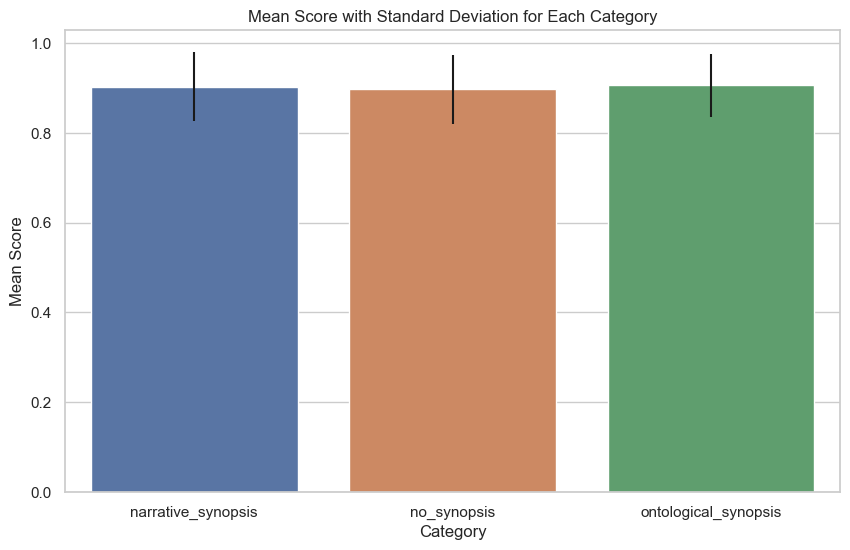

In [191]:
stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
stats_df.columns = ['category', 'mean', 'stddev']

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='category', y='mean', data=stats_df, yerr=stats_df['stddev'], capsize=.1)

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Mean Score")
plt.title("Mean Score with Standard Deviation for Each Category")

# Show the plot
plt.show()


In [192]:
diff_summary = result.groupby([MODEL, METHOD])['length_diff'].describe()[['count', 'mean', 'std', 'min', 'max']]
diff_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## Unparsed

In [193]:
def unparsed(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

## Potential Hallucinations

Summarize all GO terms that are in all summaries that are not in the closure of annotated terms for any of the genes in the gene set

In [194]:
def hallucinatons(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

In [195]:
novel_df_turbo = hallucinatons(df, TURBO).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
novel_df_turbo

NAME  \
0                                                      regulation of carbohydrate metabolic process   
1                                                                              seedling development   
2                                               production of molecular mediator of immune response   
3                                        obsolete glyceraldehyde-3-phosphate dehydrogenase activity   
4                                                 regulation of response to reactive oxygen species   
5                                           obsolete transcription factor activity, protein binding   
6                                                         obsolete transcription activator activity   
7                                                          regulation of collagen metabolic process   
8                                                           post-translational protein modification   
9                                                                                   protein folding   
10                                                                    obsolete cell surface binding   
11                                                                proteoglycan biosynthetic process   
12                                                                                   protein import   
13                                                                                  lipid transport   
14                                                                           platelet degranulation   
15                                                                   regulation of bone development   
16                                                                   proteoglycan metabolic process   
17                                                regulation of synaptic transmission, dopaminergic   
18                                                                calcium-dependent protein binding   
19                                    regulation of presynaptic cytosolic calcium ion concentration   
20                                                        regulation of synaptic vesicle exocytosis   
21                                                      endoplasmic reticulum membrane organization   
22                                                      regulation of muscle filament sliding speed   
23                                       positive regulation of phosphoprotein phosphatase activity   
24                                                                            calcium ion transport   
25                                                              P-type calcium transporter activity   
26                                                                   acetylcholine receptor binding   
27                                                                     obsolete lipoprotein binding   
28                                                                                obsolete collagen   
29                                                                    muscle thin filament assembly   
30                                                                           obsolete membrane part   
31                                                                UDP-D-galactose metabolic process   
32                                                         regulation of neurotransmitter secretion   
33                                                                  regulation of protein stability   
34                                                        calcium-dependent protein kinase activity   
35                                                                calcium-dependent ATPase activity   
36                                                            embryonic skeletal system development   
37                                                                                 bone development   
38                                                                       neuro

In [196]:
hallucinatons(df, DAVINCI)

NAME  \
0                                                 pentose-phosphate shunt   
1                                      transcription coactivator activity   
2                                                  sprouting angiogenesis   
3                                  protein phosphatase inhibitor activity   
4                            DNA replication-dependent chromatin assembly   
5                                obsolete small nuclear ribonucleoprotein   
6                                                    kinetochore assembly   
7                                                         DNA methylation   
8                 obsolete transcription factor activity, protein binding   
9                                          obsolete ATP catabolic process   
10                                                         actin filament   
11                              obsolete transcription activator activity   
12                                                              secretion   
13                                post-translational protein modification   
14                                                      obsolete collagen   
15                                                  inflammatory response   
16                                       obsolete phospholipid scrambling   
17                             obsolete extracellular matrix glycoprotein   
18             obsolete calcium-dependent cell adhesion molecule activity   
19                                obsolete plasminogen activator activity   
20                                                obsolete plasma protein   
21                                           obsolete matrilysin activity   
22                                             calcium-mediated signaling   
23                                                         protein import   
24                                                        obsolete lectin   
25                          obsolete protein homooligomerization activity   
26                                                        obsolete serpin   
27                                         chemical synaptic transmission   
28                                           obsolete lipoprotein binding   
29          regulation of presynaptic cytosolic calcium ion concentration   
30                              regulation of synaptic vesicle exocytosis   
31                                                       limb development   
32                                               obsolete cytochrome P450   
33                                      glycoprotein biosynthetic process   
34                                               sterol catabolic process   
35                                                          glycosylation   
36                                                        mRNA processing   
37                           positive regulation of stress fiber assembly   
38                                                      nuclear migration   
39                                                 phosphoprotein binding   
40             negative regulation of phosphoprotein phosphatase activity   
41                                                          cell motility   
42                          protein serine/threonine phosphatase activity   
43                                                cell fate determination   
44                                     structural constituent of ribosome   
45                                                dextransucrase activity   
46                            initiator methionyl aminopeptidase activity   
47                                                    histone acetylation   
48                                      UDP-D-galactose metabolic process   
49                      regulation of cytosolic calcium ion concentration   
50                                      obsolete heterotrimeric G-protein   
51                                           obsolete signal tran

In [197]:
hallucinatons(df, GPT4)

NAME  \
0                                                cellular respiration   
1          obsolete glyceraldehyde-3-phosphate dehydrogenase activity   
2             obsolete transcription factor activity, protein binding   
3                                                  protein processing   
4                                           obsolete promoter binding   
5                            obsolete covalent chromatin modification   
6                                                     protein folding   
7                                          obsolete vesicle transport   
8                                                         cell growth   
9                                   glycoprotein biosynthetic process   
10                          reactive oxygen species metabolic process   
11                                        bile acid metabolic process   
12                                                     protein import   
13                                      protein sequestering activity   
14                                      collagen biosynthetic process   
15                                                tissue regeneration   
16                                       cellular response to ethanol   
17                                   AMPA glutamate receptor activity   
18                                                 muscle hyperplasia   
19                                              calcium ion transport   
20                         obsolete striated muscle fiber development   
21                                          obsolete tumor suppressor   
22                          obsolete transcription activator activity   
23                      obsolete regulation of cAMP metabolic process   
24                  regulation of cytosolic calcium ion concentration   
25                                         calcium-mediated signaling   
26                                                        translation   
27                     microtubule polymerization or depolymerization   
28                                   anatomical structure arrangement   
29                         obsolete actin cytoskeleton reorganization   
30                                     regulation of action potential   
31                                 endoplasmic reticulum localization   
32                                                   CCR4-NOT complex   
33  proteasome-mediated ubiquitin-dependent protein catabolic process   
34                                                  ribosome assembly   
35                          obsolete transcription repressor activity   
36                                        obsolete electron transport   
37                                               nucleus localization   
38                  programmed DNA elimination by chromosome breakage   
39                                                 tissue homeostasis   
40                                    cellular response to tumor cell   
41                                          immunoglobulin production   
42                                                  B cell activation   
43                                              complement activation   
44                                     glycoprotein catabolic process   
45            RNA splicing, via endonucleolytic cleavage and ligation   
46                                           translational elongation   
47                                                   centrosome cycle   
48                                               cellular homeostasis   
49       peroxisome proliferator activated receptor signaling pathway   
50                                               chemokine production   
51                                               obsolete oncogenesis   
52                                 regulation of telomere maintenance   
53                                                 LEM domain binding   
54                                               t

In [198]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
enc.encode("negative regulation")

def tok_similarity(t1, t2):
    if t1 is None and t2 is None:
        return 1
    if t1 is None or t2 is None:
        return 0

    toks1 = set(enc.encode(t1))
    toks2 = set(enc.encode(t2))
    return len(toks1.intersection(toks2)) / len(toks1.union(toks2))


In [199]:
closure_by_gene_set = {}
for comp in comps:
    closure = comp.payloads["closure"].term_strings
    closure_by_gene_set[comp.name] = closure

def hallucinatons_with_best_match(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        # print(gs)
        closure = closure_by_gene_set[gs]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            # sims = [(ct, text_similarity(ct, lbl)) for ct in closure]
            sims = [(ct, tok_similarity(ct, lbl)) for ct in closure]
            sims = sorted(sims, key=lambda x: -x[1])
            best = sims[0][0]
            novel_term_map[lbl][m].append((gs, best))
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

novel_df_turbo = hallucinatons_with_best_match(df, TURBO).reset_index(drop=True)
novel_df_turbo

NAME  \
0                                                      regulation of carbohydrate metabolic process   
1                                                                              seedling development   
2                                               production of molecular mediator of immune response   
3                                        obsolete glyceraldehyde-3-phosphate dehydrogenase activity   
4                                                 regulation of response to reactive oxygen species   
5                                           obsolete transcription factor activity, protein binding   
6                                                         obsolete transcription activator activity   
7                                                          regulation of collagen metabolic process   
8                                                           post-translational protein modification   
9                                                                                   protein folding   
10                                                                    obsolete cell surface binding   
11                                                                proteoglycan biosynthetic process   
12                                                                                   protein import   
13                                                                                  lipid transport   
14                                                                           platelet degranulation   
15                                                                   regulation of bone development   
16                                                                   proteoglycan metabolic process   
17                                                regulation of synaptic transmission, dopaminergic   
18                                                                calcium-dependent protein binding   
19                                    regulation of presynaptic cytosolic calcium ion concentration   
20                                                        regulation of synaptic vesicle exocytosis   
21                                                      endoplasmic reticulum membrane organization   
22                                                      regulation of muscle filament sliding speed   
23                                       positive regulation of phosphoprotein phosphatase activity   
24                                                                            calcium ion transport   
25                                                              P-type calcium transporter activity   
26                                                                   acetylcholine receptor binding   
27                                                                     obsolete lipoprotein binding   
28                                                                                obsolete collagen   
29                                                                    muscle thin filament assembly   
30                                                                           obsolete membrane part   
31                                                                UDP-D-galactose metabolic process   
32                                                         regulation of neurotransmitter secretion   
33                                                                  regulation of protein stability   
34                                                        calcium-dependent protein kinase activity   
35                                                                calcium-dependent ATPase activity   
36                                                            embryonic skeletal system development   
37                                                                                 bone development   
38                                                                       neuro

## New Annotations

In [200]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

id  \
0                                                            GO:0006907   
1                                                            GO:0006897   
2                                                            GO:0044351   
3                                                            GO:0016192   
4                                                            GO:0030100   
5                                                            GO:0006810   
6                                                            GO:0051234   
7                                                            GO:0045807   
8                                                            GO:0060627   
9                                                            GO:0051179   
10                                                           GO:0031410   
11                                                           GO:0097708   
12                                                           GO:0050766   
13                                                           GO:0048518   
14                                                           GO:0050764   
15                                                           GO:0051128   
16                                                           GO:0031982   
17                                                           GO:0150094   
18                                                           GO:0006909   
19                                                           GO:0051049   
20                                                           GO:0006898   
21                                                           GO:0051050   
22                                                           GO:0005041   
23                                                           GO:0030139   
24                                                           GO:0030228   
25                                                           GO:0030666   
26                                                           GO:0097242   
27                                                           GO:0051130   
28                                                           GO:0060907   
29                                                           GO:0032879   
30                                                           GO:0048522   
31                                                           GO:0002277   
32                                                           GO:0030659   
33                                                           GO:0012506   
34                                                           GO:0061081   
35                                                           GO:0010935   
36                                                           GO:0048583   
37                                                           GO:1905167   
38                                                           GO:0009894   
39                                                           GO:0023051   
40                                                           GO:0051641   
41                                                           GO:1904352   
42                                                           GO:0070508   
43                                                           GO:0031347   
44                                                           GO:0005794   
45                                                           GO:1901700   
46                                                           GO:0061024   
47                                                           GO:0009966   
48                                                           GO:0015031   
49                                                           GO:0048523   
50                                                           GO:0032429   
51                                                           GO:0034381   
52                                                           GO:0031623   
53                 

In [201]:
viz('endocytosis-0')

![img](output/endocytosis-0-True-v1.png)

### New Annotations

in 2022-03-24, GO `molecular sequesting` only had 6 genes annotated; this increased to 30 in 2023.
If these are past the LLM training date then we would not expect these to influence results. Additionally,


In [202]:
sequestering = df.query(f"{GENESET} == 'molecular sequestering-0'").sort_values("similarity", ascending=False)
sequestering[eval_summary_cols]                                                           

has top term  in top 5  in top 10  size overlap  similarity  num terms  \
1444          True      True       True            26        1.00         26   
1445          True      True       True             9        0.28         15   
1429          True      True       True             3        0.11          6   
1435          True      True       True             2        0.07          6   
1428         False     False      False             1        0.04          7   
1434         False     False      False             1        0.04          8   
1440          True     False       True             1        0.03         19   
1441         False     False      False             1        0.03         10   
1432         False     False      False             1        0.03          8   
1447         False     False      False             1        0.02         30   
1448          True     False      False            26        0.01       2570   
1446         False     False      False             0        0.00         30   
1443         False     False      False             0        0.00         13   
1442         False     False      False             0        0.00         19   
1426         False     False      False             0        0.00          5   
1439         False     False      False             0        0.00          6   
1438         False     False      False             0        0.00          5   
1427         False     False      False             0        0.00          6   
1436         False     False      False             0        0.00          3   
1433         False     False      False             0        0.00          7   
1431         False     False      False             0        0.00         10   
1430         False     False      False             0        0.00          8   
1437         False     False      False             0        0.00          3   

      num GO terms  nr size overlap  nr similarity  mean p value  min p value  \
1444            26               10           1.00          0.02     1.83e-93   
1445            15                2           0.11          0.41     1.83e-93   
1429             4                0           0.00          0.25     1.83e-93   
1435             4                1           0.08          0.50     1.83e-93   
1428             2                0           0.00          0.50     2.83e-38   
1434             3                0           0.00          0.67     1.97e-03   
1440             6                0           0.00          0.83     1.83e-93   
1441             6                0           0.00          0.83     2.83e-38   
1432             8                1           0.06          0.88     4.66e-04   
1447            30                0           0.00          0.97     4.71e-02   
1448          2526                0           0.00          0.99     1.83e-93   
1446            30                0           0.00          1.00     1.00e+00   
1443             8                0           0.00          1.00     1.00e+00   
1442             9                0           0.00          1.00     1.00e+00   
1426             2                0           0.00          1.00     1.00e+00   
1439             2                0           0.00          1.00     1.00e+00   
1438             2                0           0.00          1.00     1.00e+00   
1427             4                0           0.00          1.00     1.00e+00   
1436             2                0           0.00          1.00     1.00e+00   
1433             7                0           0.00          1.00     1.00e+00   
1431             7                0           0.00          1.00     1.00e+00   
1430             3                0           0.00          1.00     1.00e+00   
1437             3                0           0.00          1.00     1.00e+00   

      max p value  proportion significant  num unannotated  
1444         0.05                    1.00                0  
1445         1.00 

In [203]:
terms_summary(sequestering)

id  \
0                                                                                                                                                            GO:0140313   
1                                                                                                                                                            GO:0140311   
2                                                                                                                                                            GO:0140487   
3                                                                                                                                                            GO:0048519   
4                                                                                                                                                            GO:0006950   
5                                                                                                                                                            GO:0048523   
6                                                                                                                                                            GO:0140678   
7                                                                                                                                                            GO:0048585   
8                                                                                                                                                            GO:0036316   
9                                                                                                                                                            GO:0140315   
10                                                                                                                                                           GO:0140486   
11                                                                                                                                                           GO:0140610   
12                                                                                                                                                           GO:0005488   
13                                                                                                                                                           GO:0051235   
14                                                                                                                                                           GO:0002682   
15                                                                                                                                                           GO:0010629   
16                                                                                                                                                           GO:0032937   
17                                                                                                                                                           GO:2000639   
18                                                                                                                                                           GO:0009968   
19                                                                                                                                                           GO:0000041   
20                                                                                                                                                           GO:1901222   
21                                                                                                                                                           GO:0051651   
22                                                                                                                                                           GO:0010648   
23                                                           

In [204]:
viz('molecular sequestering-0')

![img](output/molecular_sequestering-0-True-v1.png)

## IGRB

This gene set contains genes previously annotated to IGRB, many of which have been since removed

In [205]:
igrb = df.query(f"{GENESET} == 'ig-receptor-binding-2022-0'").sort_values("similarity", ascending=False)
terms_summary(igrb)

id  \
0                                                                                                                                                                                                                                                                                                                                                                                              GO:0019814   
1                                                                                                                                                                                                                                                                                                                                                                                              GO:0009897   
2                                                                                                                                                                                                                                                                                                                                                                                              GO:0098552   
3                                                                                                                                                                                                                                                                                                                                                                                              GO:0002250   
4                                                                                                                                                                                                                                                                                                                                                                                              GO:0009986   
5                                                                                                                                                                                                                                                                                                                                                                                              GO:0006955   
6                                                                                                                                                                                                                                                                                                                                                                                              GO:0002376   
7                                                                                                                                                                                                                                                                                                                                                                                              GO:0005886   
8                                                                                                                                                                                                                                                                                                                                                                                              GO:0071944   
9                                                                                                                                                                                                                                                                                                                                                                                              GO:0003823   
10                      

In [206]:
viz('ig-receptor-binding-2022-0')

![img](output/ig-receptor-binding-2022-0-True-v1.png)

In [207]:
viz('HALLMARK_GLYCOLYSIS-0')

![img](output/HALLMARK_GLYCOLYSIS-0-True-v1.png)

In [208]:
viz('HALLMARK_KRAS_SIGNALING_UP-0')

![img](output/HALLMARK_KRAS_SIGNALING_UP-0-True-v1.png)

## Summaries

In [209]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [210]:
sdf = pd.DataFrame(objs)

In [211]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

model                                                 geneset  \
0     None                                      glycolysis-gocam-0   
1     None                                      glycolysis-gocam-0   
2     None                                      glycolysis-gocam-0   
3     None                                      glycolysis-gocam-0   
4     None                                      glycolysis-gocam-0   
5     None                                      glycolysis-gocam-0   
6     None                                      glycolysis-gocam-0   
7     None                                      glycolysis-gocam-0   
8     None                                      glycolysis-gocam-0   
9     None                                      glycolysis-gocam-0   
10    None                                      glycolysis-gocam-0   
11    None                                      glycolysis-gocam-0   
12    None                                      glycolysis-gocam-0   
13    None                                      glycolysis-gocam-0   
14    None                                      glycolysis-gocam-0   
15    None                                      glycolysis-gocam-0   
16    None                                      glycolysis-gocam-0   
17    None                                      glycolysis-gocam-0   
18    None                                      glycolysis-gocam-1   
19    None                                      glycolysis-gocam-1   
20    None                                      glycolysis-gocam-1   
21    None                                      glycolysis-gocam-1   
22    None                                      glycolysis-gocam-1   
23    None                                      glycolysis-gocam-1   
24    None                                      glycolysis-gocam-1   
25    None                                      glycolysis-gocam-1   
26    None                                      glycolysis-gocam-1   
27    None                                      glycolysis-gocam-1   
28    None                                      glycolysis-gocam-1   
29    None                                      glycolysis-gocam-1   
30    None                                      glycolysis-gocam-1   
31    None                                      glycolysis-gocam-1   
32    None                                      glycolysis-gocam-1   
33    None                                      glycolysis-gocam-1   
34    None                                      glycolysis-gocam-1   
35    None                                      glycolysis-gocam-1   
36    None                               bicluster_RNAseqDB_1001-0   
37    None                               bicluster_RNAseqDB_1001-0   
38    None                               bicluster_RNAseqDB_1001-0   
39    None                               bicluster_RNAseqDB_1001-0   
40    None                               bicluster_RNAseqDB_1001-0   
41    None                               bicluster_RNAseqDB_1001-0   
42    None                               bicluster_RNAseqDB_1001-0   
43    None                               bicluster_RNAseqDB_1001-0   
44    None                               bicluster_RNAseqDB_1001-0   
45    None                               bicluster_RNAseqDB_1001-0   
46    None                               bicluster_RNAseqDB_1001-0   
47    None                               bicluster_RNAseqDB_1001-0   
48    None                               bicluster_RNAseqDB_1001-0   
49    None                               bicluster_RNAseqDB_1001-0   
50    None                               bicluster_RNAseqDB_1001-0   
51    None                               bicluster_RNAseqDB_1001-0   
52    None                               bicluster_RNAseqDB_1001-0   
53    None                               bicluster_RNAseqDB_1001-0   
54    None                               bicluster_RNAseqDB_1001-1   
55    None                               bicluster_RNAseqDB_1001-1   
56    None     

In [212]:
sdf.query("geneset == 'sensory ataxia-0'")

model           geneset                                    method  \
1836  None  sensory ataxia-0                      gpt-4.no_synopsis.v1   
1837  None  sensory ataxia-0                      gpt-4.no_synopsis.v2   
1838  None  sensory ataxia-0             gpt-4.ontological_synopsis.v1   
1839  None  sensory ataxia-0             gpt-4.ontological_synopsis.v2   
1840  None  sensory ataxia-0               gpt-4.narrative_synopsis.v1   
1841  None  sensory ataxia-0               gpt-4.narrative_synopsis.v2   
1842  None  sensory ataxia-0              gpt-3.5-turbo.no_synopsis.v1   
1843  None  sensory ataxia-0              gpt-3.5-turbo.no_synopsis.v2   
1844  None  sensory ataxia-0     gpt-3.5-turbo.ontological_synopsis.v1   
1845  None  sensory ataxia-0     gpt-3.5-turbo.ontological_synopsis.v2   
1846  None  sensory ataxia-0       gpt-3.5-turbo.narrative_synopsis.v1   
1847  None  sensory ataxia-0       gpt-3.5-turbo.narrative_synopsis.v2   
1848  None  sensory ataxia-0           text-davinci-003.no_synopsis.v1   
1849  None  sensory ataxia-0           text-davinci-003.no_synopsis.v2   
1850  None  sensory ataxia-0  text-davinci-003.ontological_synopsis.v1   
1851  None  sensory ataxia-0  text-davinci-003.ontological_synopsis.v2   
1852  None  sensory ataxia-0    text-davinci-003.narrative_synopsis.v1   
1853  None  sensory ataxia-0    text-davinci-003.narrative_synopsis.v2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          summary  
1836                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Summary: Enriched terms associated with the given list of genes are mostly involved in the development and maintenance of t